# Deep Learning
## Summative assessment
### Coursework 1

#### Instructions

This coursework is released on **Tuesday 18th February 9.00** and is due by **Tuesday 11th March 9.00**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 50 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks shown per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for face verification. This is the problem of determining whether or not two images are of the same person.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

The data required for this assessment can also be downloaded from [this link](https://drive.google.com/file/d/1guvJwIdHKi4-AFRPs0v-6kfHZhEuo8x8/view?usp=sharing) in case you would prefer to work locally.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and PDF report.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook and separate PDF/HTML file(s) by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
# You will need the following imports for this assessment. You can make additional imports when you need them
import os
from functools import partial

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import matplotlib.pyplot as plt
import numpy as np

print(keras.backend.backend())


tensorflow


#### CASIA-Webface Dataset

This assessment makes use of the CASIA-Webface dataset, which is used for face verification and face identification tasks. The complete dataset consists of 494,414 face images of 10,575 real identities collected from the web. In this assessment, a smaller subset of the dataset has been prepared for you.

The dataset was first introduced in the following paper:

*  Yi, D., Lei, Z., Liao, S. and Li, S.Z. (2014), "Learning Face Representation from Scratch", arXiv preprint, abs/1411.7923.

The data subset is available for you in the folder `./data/casia-webface`.

 #### Contrastive learning

Your task in this assessment is to develop a deep learning model that can be used to verify if two images belong to the same person or not. The model will take an image as input, and output a fixed size embedding. The model will be trained such that different images belonging to the same identity should have embeddings that are close to each other (in some sense), and images belonging to different identities should have embeddings that are far apart.

The training algorithm you will use for this will be a form of contrastive learning. This is a learning paradigm where the objective function compares different examples in the dataset.

In particular, to train your model you will use a loss function that takes three examples: an anchor input $\mathbf{x}$, a positive example $\mathbf{x}^+$ that is similar to the anchor (the same identity), and a negative example $\mathbf{x}^-$ that is different to the anchor. The objective for the network is to embed the images such that the similarity between the anchor and positive example is maximised (or distance is minimised), and the similarity between the anchor and negative example is minimised (distance is maximised).

<center><img src="figures/contrastive-learning.png" alt="Similarity of representations" style="width: 450px;"/></center>
<center>The model's objective is to minimize the distance (in embedding space) between an anchor and a positive example, both of which have the same identity, and maximize the distance between the anchor and a negative example of a different identity</center>
<br>

The loss function you will use is the circle loss, given by:

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$
where $s_p$ (resp. $s_n$) is the positive (resp. negative) similarity score computed between the anchor and positive (resp. anchor and negative) examples, according to some choice of similarity measure in the embedding space. The hyperparameters $\alpha_p>0$ and $\alpha_n>0$ are example-specific weightings to emphasise either the positive or negative similarity scores in the gradient updates, and $\Delta_p>0$ and $\Delta_n>0$ are the positive and negative margins. 

The circle loss was introduced in the following paper:

* Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

You will need to implement a custom data loading pipeline and custom training loop, as well as designing a dedicated model architecture that produces an embedding for a given input image. Details of the data loading and training procedures will be up to you to decide. You will process the data, train and evaluate the specified model, and then write a report to summarise the experiments and results.

The data processing, model design, training algorithm and evaluation will potentially require several hyperparameter choices, and you should experiment with different choices during the development of your model. In question 4 you will write a report detailing the experiments carried out. It is up to you which experiments you will run. It is not necessary to include all experiments carried out in code in this notebook - you only need to include the code for the final choice of hyperparameters (in order to avoid overly long notebook submissions).

### Question 1 (Total 8 marks)

a) In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. For example, it will be helpful to compute the number of distinct identities in the dataset, and visualise some of the images. You can also use comments and/or markdown as appropriate.

**(3 marks)**

### Solutions 1a. Initial Data Exploration

Tasks:

1. Find the number of directories in the ./data/casia-webface. This corresponds to the number of distinct faces.
2. Check how many photos we have on average per person. Is it the same for all people?
3. Load 9 photos. Inspect their dimensions and visualise them
4. Depending on how many photos there are, try to create a dataframe with one row per photo, having the dimensions and label of which person it belongs to?

In [2]:
# Number of directories
from pathlib import Path

root_path = Path('./data/casia-webface/')
dirs = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
# set(os.listdir(root_path)).difference(dirs) = .DS_Store
print(f'Number of directories/distinct faces: {len(dirs)}')

Number of directories/distinct faces: 8000


In [3]:
# Number of photos per person/statistics on number of photos
photos_per_person = np.array([len(os.listdir(os.path.join(root_path, d))) for d in dirs])
print(
    f'Average no of photos per person: {photos_per_person.mean():.0f}\nMax number of photos per person: {photos_per_person.min()}\nMin number of photos per person: {photos_per_person.max()}')

Average no of photos per person: 26
Max number of photos per person: 10
Min number of photos per person: 50


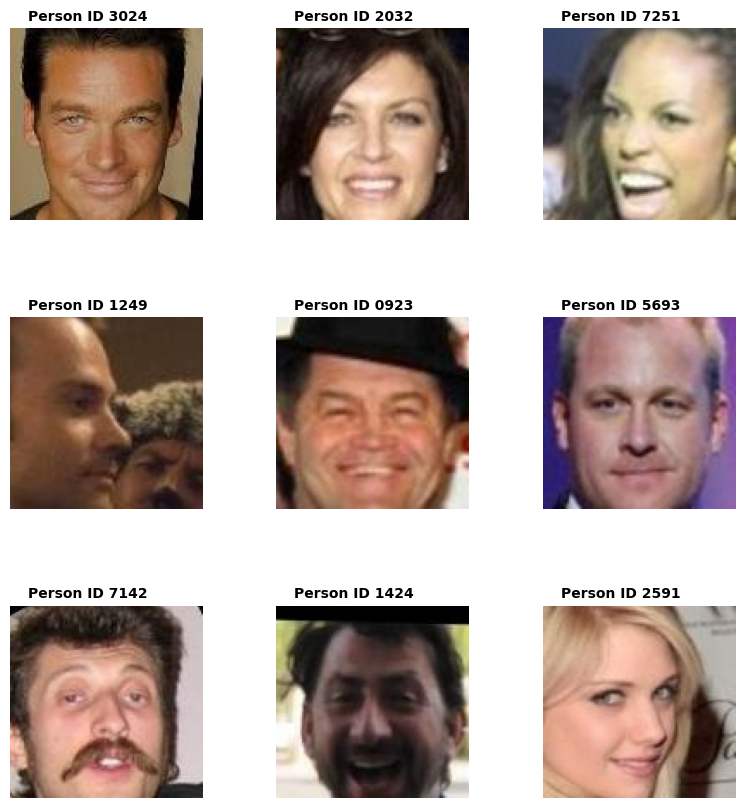

In [4]:
# Load 9 photos
# need to load the photos into a numpy array
all_photos = [os.path.join(root_path, d, p) for d in dirs for p in os.listdir(os.path.join(root_path, d))]
sample_photos = np.random.choice(all_photos, 9, replace=False)

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for n, p in enumerate(sample_photos):
    row = n // n_cols
    col = n % n_cols
    photo = keras.utils.load_img(p)
    photo = keras.utils.img_to_array(photo, dtype='int32')
    axes[row, col].imshow(photo)
    axes[row, col].axis('off')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    person_id = p.rsplit('/', 2)[-2]
    axes[row, col].text(10., -5, f'Person ID {person_id}', fontsize=10, color='black', weight='bold')
plt.show()

In [5]:
def process_image(image_path) -> tuple:
    '''
    Helper function to get the details of each image in the dataset
    :param image_path: relative path of each image
    :return: tuple with person_id, photo_id, height, width, channels
    '''
    image = keras.utils.load_img(image_path)
    image = keras.utils.img_to_array(image, dtype='int32')
    person_id, photo_id = image_path.rsplit('/', 2)[-2:]
    if len(image.shape) == 2:
        return person_id, photo_id, image.shape[0], image.shape[1], 1
    return person_id, photo_id, image.shape[0], image.shape[1], image.shape[2]


import pandas as pd
from joblib import Parallel, delayed

results = Parallel(n_jobs=-1)(delayed(process_image)(p) for p in all_photos)
df = pd.DataFrame(results, columns=['person_id', 'photo_id', 'height', 'width', 'channels'])


In [6]:
# inspect whether all photos have the same dimensions (unlikely unless the dataset was pre-processed)
df[['height', 'width', 'channels']].describe()

,height,width,channels
count,211958.0,211958.0,211958.0
mean,112.0,112.0,3.0
std,0.0,0.0,0.0
min,112.0,112.0,3.0
25%,112.0,112.0,3.0
50%,112.0,112.0,3.0
75%,112.0,112.0,3.0
max,112.0,112.0,3.0


In [7]:
# Look at one of the photo arrays. Verify the pixel values range from 0 to 255
photo = keras.utils.load_img(all_photos[0])
photo = keras.utils.img_to_array(photo, dtype='int32')
print(photo[:2, :2, :])

[[[55 53 67]
  [55 53 67]]

 [[56 54 68]
  [56 54 68]]]


### Summary of Results

There are 8,000 distinct faces, with 10 to 50 photos per person and an average of 26 photos per person. The total number of photos is 211,958.
All photos have dimension 112x112x3 and the pixels range from 0 to 255 (RGB).

b) Create the dataset object(s) that you will use to train and evaluate your model. The only requirements for your datasets are as follows:

* You should use either TensorFlow Datasets or PyTorch Datasets/DataLoaders. 
* A number of identities should be selected, and for each identity a maximum number of images should be selected.
* The dataset should return an aligned pair of Tensors `(identities, images)` with shapes `(N,)` and `(N, height, width, channels)`, where `N` is the total number of images selected across all selected identities.

You can use any tools from Keras, TensorFlow or PyTorch that might be useful for this task.

Demonstrate that your dataset creation and processing is working as intended.

**(5 marks)**

### Solutions 1b. Dataset Creation

* Use `torch` (better performance on Apple Silicon).
* Write a helper function called `load_images` which returns the labels and images as Tensors.
    * Use `torchvision` to apply transformations to the images
    * Allow for additional image transformations (might be useful to use data augmentation later)
* Write a function called `get_dataloader` which returns the dataloader for the dataset. This should take the same parameters as the helper function plus the batch size and shuffle option.

Function parameters: the path, number of people (fixed), max number of photos per person, additional transforms.


In [8]:
# Torch DataLoaders appear to be slightly
from PIL import Image
import torch
from torchvision import transforms
from typing import Optional, Tuple


def load_images(root_path: str, max_photos_per_person: int = 50, no_people: int = 1000,
                img_transforms: Optional[list] = None, seed: int = 42) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Helper function for loading and creating the dataloaders
    :param root_path: path to the dataset
    :param max_photos_per_person: maximum number of photos per person (max possible is 10)
    :param no_people: number of distinct identities (max possible is 8000)
    :param img_transforms: optional image transformations, in a list format. Need to be compatible with torchvision.transforms
    (torch.nn.Module) and should operate on an image tensor (not a PIL array)
    :param seed: random seed for reproducibility
    :return: tuple of labels and images
    '''
    np.random.seed(seed)
    all_people = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    selected_people = np.random.choice(all_people, min(no_people, len(all_people)), replace=False)

    img_transforms_ = [transforms.ToTensor(),  # -> torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
                       transforms.ConvertImageDtype(torch.float32)]
    img_transforms_.extend(img_transforms or [])
    img_transforms_ = transforms.Compose(img_transforms_)

    img_list = []
    label_list = []
    for label_id, person in enumerate(selected_people):
        person_path = os.path.join(root_path, person)
        all_files = os.listdir(person_path)
        selected_files = all_files[:max_photos_per_person]
        for f in selected_files:
            img_path = os.path.join(person_path, f)
            img = Image.open(img_path)  # already in RGB here.
            img_tensor = img_transforms_(img)
            img_list.append(img_tensor)
            label_list.append(label_id)

    img_tensor = torch.stack(img_list, dim=0)  # shape N, C, H, W
    img_tensor = img_tensor.permute(0, 2, 3, 1)
    label_tensor = torch.from_numpy(np.array(label_list).astype(np.int32).reshape(-1))
    return label_tensor, img_tensor


labels, images = load_images(root_path=root_path, max_photos_per_person=2, no_people=3, img_transforms=None)
print(labels)  # expected [0, 0, 1, 1, 2, 2]
print(images.shape)  # expected (6, 112, 112, 3)

tensor([0, 0, 1, 1, 2, 2], dtype=torch.int32)
torch.Size([6, 112, 112, 3])


In [9]:
def get_dataloader(root_path: str, batch_size: int, shuffle: bool, max_photos_per_person: int = 50,
                   no_people: int = 1000, img_transforms: Optional[list] = None,
                   seed: int = 42) -> torch.utils.data.DataLoader:
    '''
    Function to get the dataloader for the dataset
    :param root_path: path to the dataset
    :param batch_size: batch size for the dataloader
    :param shuffle: whether to shuffle the dataset
    :param max_photos_per_person: maximum number of photos per person (max is 10)
    :param no_people: maximum number of people (max is 8000)
    :param img_transforms: optional image transformations, in a list format. Need to be compatible with torchvision.transforms
    (torch.nn.Module) and should operate on an image tensor (not a PIL array)
    :param seed: random seed for reproducibility
    :return: dataloader for the dataset
    '''
    labels, images = load_images(root_path, max_photos_per_person, no_people, img_transforms, seed)
    dataset = torch.utils.data.TensorDataset(labels, images)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [10]:
dataloader_test = get_dataloader(root_path, batch_size=2, shuffle=True, max_photos_per_person=2, no_people=3,
                                 img_transforms=None)

# Check that shuffle gets us all permutations of batches and validate the sizes and shapes
# Expected: 2 batches of 2 images each
for i, (l, p) in enumerate(dataloader_test):
    print(f'Batch {i}:\nLabels: {l}\nPhotos: {p.shape}')


Batch 0:
Labels: tensor([0, 2], dtype=torch.int32)
Photos: torch.Size([2, 112, 112, 3])
Batch 1:
Labels: tensor([1, 1], dtype=torch.int32)
Photos: torch.Size([2, 112, 112, 3])
Batch 2:
Labels: tensor([0, 2], dtype=torch.int32)
Photos: torch.Size([2, 112, 112, 3])


In [11]:
# Try an additional transform:
from torchvision.transforms import v2

img_transforms = [v2.RandomAdjustSharpness(sharpness_factor=10, p=1)]

original = get_dataloader(root_path, batch_size=1, shuffle=False, max_photos_per_person=1, no_people=1)
sharpened = get_dataloader(root_path, batch_size=1, shuffle=False, max_photos_per_person=1, no_people=1,
                           img_transforms=img_transforms)

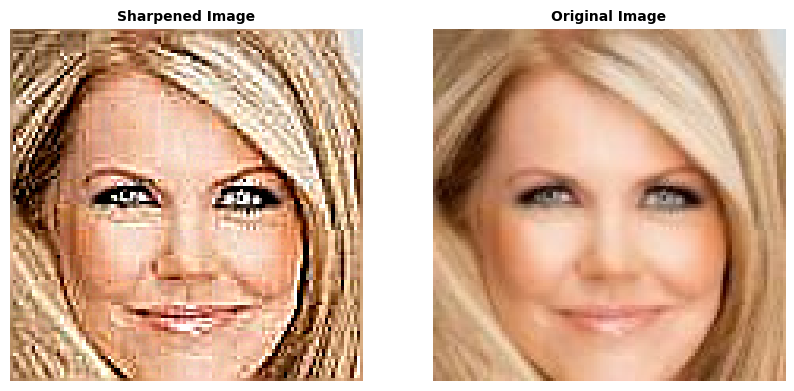

In [12]:
# Visualise the sharpened image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sharpened.dataset.tensors[1][0].detach().numpy())
axes[0].axis('off')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].set_title('Sharpened Image', fontsize=10, color='black', weight='bold')
axes[1].imshow(original.dataset.tensors[1][0].detach().numpy())
axes[1].axis('off')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].set_title('Original Image', fontsize=10, color='black', weight='bold')

plt.show()

#### Version 2 (Used Later)

Although we believe the question expects the above implementation, we chose to implement a custom `Dataset` class that we will use for our training.

**`ImageDataset` specifications:**
* The constructor takes the following arguments: `no_photos`, `img_transforms` (optional), `augment` . If `img_transforms` is not provided, the default option is used. The `augment` argument is a boolean flag that indicates whether to apply the `img_transforms` to the images. This allows us to get a richer training dataset. For testing this should be `False`.
* The `__len__` method returns the number of identities available
* The `__getitem__` method takes an index and returns a tuple of tensors corresponding to (identities, images) with shapes (K,), (K, height, width, channels) where K = `no_photos`
* If there are fewer than `no_photos` images for a given identity, additional photos are generated using the `img_transforms`.

**`Dataloader` specifications:**

The new `get_dataloader` method does not take a batch size, instead it computes it using the number of people and number of photos requested.


In [13]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, no_photos, img_transforms: Optional[list], augment: bool = False, test: bool = False):
        '''
         Custom dataset class to sample an identity and return no_photos of that identity
        :param no_photos: Integer, the number of images to return per sample
        :param img_transforms: optional list of image transformations
        :param augment: Whether the images should be transformed. Note that at test time
        any transforms should be deterministic
        :para test: If test is False, the identities are selected from the first 1768 (=8000-32) of the identities and they are
        shuffled before being drawn. If true then the last 32 identities are used
        '''
        self.root_dir = Path('./data/casia-webface/')
        self.no_photos = no_photos
        if img_transforms:
            self.extra_transforms = img_transforms
        else:
            self.extra_transforms = []

        default_img_gen_transf = [transforms.RandomHorizontalFlip(p=0.5),  # Flipping images
                                  transforms.Pad(10),  # Zero padding (common in person re-ID)
                                  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4,
                                                         hue=0.1),  # Color variations
                                  transforms.RandomPerspective(distortion_scale=0.5,
                                                               p=0.3),
                                  transforms.Resize((112, 112))]
        self.default_transforms = [transforms.ToTensor(),
                                   # -> torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
                                   transforms.ConvertImageDtype(torch.float32),
                                   transforms.Resize((112, 112))]
        self.transforms = transforms.Compose(self.default_transforms + self.extra_transforms)
        self.img_generating_transforms = transforms.Compose(
            self.default_transforms + (default_img_gen_transf or self.extra_transforms))
        self.augment = augment or img_transforms
        self.__set_labels(test=test)

    def __set_labels(self, test: bool):
        labels = sorted([x for x in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, x))])
        if test:
            self.labels = labels[-32:]
        else:
            labels = labels[:-32]
            np.random.shuffle(labels)
            self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        identity = self.labels[idx]
        img_paths = [os.path.join(self.root_dir, identity, x) for x in
                     os.listdir(os.path.join(self.root_dir, identity))]

        if len(img_paths) >= self.no_photos:
            img_paths = np.random.choice(img_paths, size=self.no_photos, replace=False)
            extra = 0
        else:
            extra = self.no_photos - len(img_paths)

        img_list = []
        for img_path in img_paths:
            img = Image.open(img_path)  # already in RGB here.
            img_tensor = self.transforms(img)
            img_list.append(img_tensor)

        if extra:
            for i in range(extra):
                img = Image.open(np.random.choice(img_paths, size=1))
                img_tensor = self.img_generating_transforms(img)
                img_list.append(img_tensor)

        img_tensor = torch.stack(img_list, dim=0)  # shape N, C, H, W
        img_tensor = img_tensor.permute(0, 2, 3, 1)
        label_tensor = torch.from_numpy(np.repeat(idx, self.no_photos).astype(np.int32))
        return label_tensor, img_tensor


def collate_fn(batch):
    '''
    Custom collate function to be used with the dataloader
    :param batch: batch of data
    :return: collated batch
    '''
    labels, images = zip(*batch)
    labels = torch.cat(labels, dim=0)
    images = torch.cat(images, dim=0)
    return labels, images


# overwrite the previous method - not clean code but this is a notebook so ...
def get_dataloader(no_people: int = 32, no_photos: int = 4, img_transforms: Optional[list] = None,
                   shuffle: bool = False, augment: bool = False, collate_fn=collate_fn, **kwargs):
    '''
        Function to get the dataloader for the dataset

    :param no_people: Number of people to sample
    :param no_photos: Number of photos to return per person
    :param img_transforms: an optional list of transformations to be applied to the image (after it is converted to a tensor so ensure compatibility)
    :param shuffle: If true, samples are shuffled
    :param augment: If True the images are augmented
    :param collate_fn: Collate function. This is used to transform the shape of the batch. By default, given our dataset, the batches would consist of a 2d tuple with dimensions:
        (no_people, no_photos) <-- labels
        (no_people, no_photos, 112, 112, 3) <-- images
    both are fine since we are anyway writing a custom training loop, but we added the collate function to be in line with the exercise
    :return: the dataloader to be used for training the model
    '''
    dataset = ImageDataset(no_photos=no_photos, img_transforms=img_transforms, augment=augment, test=not shuffle)
    return torch.utils.data.DataLoader(dataset, batch_size=no_people, shuffle=shuffle, drop_last=True,
                                       collate_fn=collate_fn, **kwargs)


In [14]:
dataloader_train = get_dataloader(augment=False, shuffle=True)
# expected length is int(7968 identities / 32 identities per batch) = 249
print(len(dataloader_train))

batch = next(iter(dataloader_train))
labels, images = batch
# expected a set of 32 distinct labels/identities
print(len(set(labels.numpy())))

# expected (128,) (128, 112, 112, 3)
print(labels.shape)
print(images.shape)

249
32
torch.Size([128])
torch.Size([128, 112, 112, 3])


In [15]:
dataloader_test = get_dataloader(augment=False, shuffle=False)
# expected length is int(32 identities / 32 identities per batch) = 1
print(len(dataloader_test))

batch = next(iter(dataloader_test))
labels, images = batch
# expected a set of 32 distinct labels/identities
print(len(set(labels.numpy())))

# expected (128,) (128, 112, 112, 3)
print(labels.shape)
print(images.shape)

1
32
torch.Size([128])
torch.Size([128, 112, 112, 3])


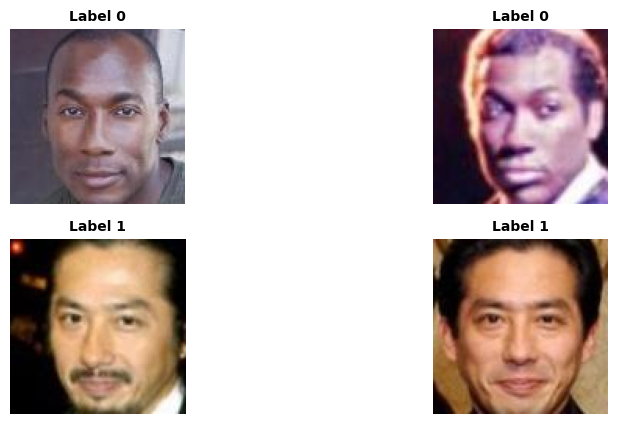

In [16]:
sample_data = get_dataloader(no_people=2, no_photos=2, shuffle=True, augment=True)
labels, images = next(iter(sample_data))

images = images.flatten().reshape(2, 2, 112, 112, 3)
# Visualise the sharpened image
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(images[i, j, ...].detach().numpy())
        axes[i, j].axis('off')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        axes[i, j].set_title(f'Label {i}', fontsize=10, color='black', weight='bold')

plt.show()

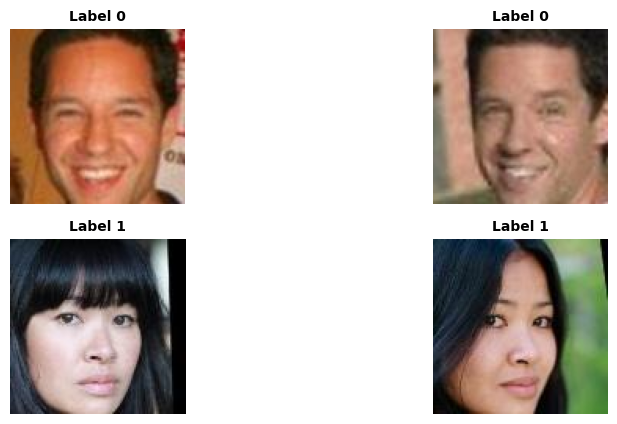

In [17]:
# Repeat to check if Dataloader shuffles or if they are always in the same order. If they are always in the same order, the same people will be appearing together
# It is OK - if shuffle = True they get shuffled otherwise it's the same images

sample_data = get_dataloader(no_people=2, no_photos=2, shuffle=True, augment=True)
labels, images = next(iter(sample_data))
images = images.flatten().reshape(2, 2, 112, 112, 3)
# Visualise the sharpened image
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(images[i, j, ...].detach().numpy())
        axes[i, j].axis('off')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        axes[i, j].set_title(f'Label {i}', fontsize=10, color='black', weight='bold')

plt.show()


### Question 2 (Total 20 marks)

a) Recall the circle loss is given by

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],\tag{1}
$$

where $\alpha_p>0$, $\alpha_n>0$, $\Delta_p>0$ and $\Delta_n>0$ are hyperparameters, and $s_p$ and $s_n$ are the similarity scores between anchor-positive and anchor-negative pairs according to some similarity measure.

The [triplet loss](https://en.wikipedia.org/wiki/Triplet_loss) is a similar loss function for contrastive learning that was developed a few years earlier. It is given by:

$$
\mathcal{L}_{\textrm{triplet}}(\mathbf{x}, \mathbf{x}^+, \mathbf{x}^-) =  \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2  + m)\tag{2}
$$

where $f_\theta$ is a network that maps images to a fixed-size embedding, $\mathbf{x}$ is an anchor example, $\mathbf{x}^+$ is a corresponding positive example, and $\mathbf{x}^-$ is a negative example, and $m>0$ is a hyperparameter that sets the minimum offset between distances of similar vs dissimilar pairs. 

Show that the triplet loss can be derived from the circle loss as a certain limit, with a certain choice of hyperparameters $\alpha_p$, $\alpha_n$, $\Delta_p$ and $\Delta_n$ and similarity measure.

**(2 marks)**

### Solutions 2a. Triplet Loss Derivation

We begin by noting that
$$
\lim_{\gamma \to \infty} \frac{1}{\gamma}\log(1 + \exp(\gamma x)) = \max(0, x).
$$


_Proof_


If $x<0$,
$$
\lim_{\gamma \to \infty} \frac{1}{\gamma} \log(1 + \exp(-\gamma |x|)) = 0
$$
and if $x > 0$,
$$
\lim_{\gamma \to \infty} \frac{1}{\gamma} \log(1 + \exp(\gamma x)) \approx \lim_{\gamma \to \infty} \frac{1}{\gamma}\log (\exp(\gamma x)) = \lim_{\gamma \to \infty} x = x.
$$

Next, we choose the similarity score to be the negative squared Euclidean distance between the embedded images which means that the smaller the distance between two embeddings, the larger the similarity score. We can write the similarity scores as
\begin{array}{l}
s_p = -||f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)||_2^2 \\
s_n = -||f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)||_2^2
\end{array}
Inspecting the triplet loss, we can see that the coefficients of the squared distances are equal to 1, hence we need to choose $\alpha_p = \alpha_n = 1$.
Finally, by $\Delta_p - \Delta_n = m$, the circle loss reduces to the triplet loss.

To summarise, in the limit $\gamma \to \infty$ (hard mining), and for $\alpha_n = \alpha_p = 1$, $\Delta_p - \Delta_n = m$ (reduction in the number of hyperparameters), the circle loss reduces to the triplet loss if we choose the similarity metric to be the negative square distance between the embeddings.

b) You will use the circle loss to train your model. Following Sun et al., we will assume that the similarity score takes values between 0 and 1. A suitable choice of similarity measure that satisfies this is the scaled cosine similarity $s(\mathbf{x}_1, \mathbf{x}_2) = (\langle \mathbf{x}_1, \mathbf{x}_2 \rangle + 1) / 2$, where $\mathbf{x}_1$ and $\mathbf{x}_2$ have been normalised such that $||\mathbf{x}_1||_2 = ||\mathbf{x}_2||_2 = 1$.

With this choice, typical settings for the hyperparameters in the circle loss are

$$
\begin{align}
\alpha_p &= 1 + m - s_p\\
\alpha_n &= s_n + m\\
\Delta_p &= 1 - m\\
\Delta_n &= m
\end{align}
$$

where $0<m<1$ is the _margin_. These settings reduce the hyperparameters in the loss function to just one (the margin $m$).

Write a function `circle_loss` to implement the circle loss as described above. Your loss function implementation should therefore take the following arguments:

* `anchor_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the anchor images
* `positive_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the corresponding positive images
* `negative_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised  model embeddings for the corresponding negative images
* `m`, a float value between zero and 1: the margin
* `gamma`, a positive float: scaling hyperparameter in the circle loss

**(2 marks)**

### Solutions 2b. Implementation of Circle Loss

* Write a function called `circle_loss` to compute circle loss:
$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$ where all parameters are given in terms of the similarity scores, $m$ and $\gamma$, as defined above.


In [18]:
def scaled_cosine_similarity(a, b):
    '''
    Computes the scaled cosine similarity between two (batches) of vectors, row-wise
    :param a: Tensor of shape (N, d) (l2 normalised embeddings)
    :param b: Tensor of shape (N, d) (l2 normalised embeddings)
    :return: Tensor of shape (N,) containing scaled cosine similarities between each pair.
    '''
    cos_sim = keras.ops.sum(a * b, axis=-1)
    return (cos_sim + 1) / 2


def circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings,
                m=0.2, gamma=256):
    '''
    Computes the Circle Loss as described in the assignment, using Keras ops.

    :param anchor_embeddings: Tensor of shape (N, d), l2-normalised embeddings for anchor images.
    :param positive_embeddings: Tensor of shape (N, d), l2-normalised embeddings for positive images.
    :param negative_embeddings: Tensor of shape (N, d), l2-normalised embeddings for negative images.
    :param m: Margin parameter, typically between 0 and 1.
    :param gamma: Scaling hyperparameter in the circle loss.
    :return: Scalar tensor representing the mean circle loss over the batch.
    '''
    anchor_embeddings = keras.ops.normalize(anchor_embeddings, axis=-1)
    positive_embeddings = keras.ops.normalize(positive_embeddings, axis=-1)
    negative_embeddings = keras.ops.normalize(negative_embeddings, axis=-1)

    # Similarities (scaled cosine similarity between corresponding rows)
    sp = scaled_cosine_similarity(anchor_embeddings, positive_embeddings)
    sn = scaled_cosine_similarity(anchor_embeddings, negative_embeddings)

    # Compute alpha and delta terms
    alpha_p = keras.ops.relu(1 + m - sp)  # ensures min=0
    alpha_n = keras.ops.relu(sn + m)
    delta_p = 1 - m
    delta_n = m

    logit_p = - alpha_p * (sp - delta_p)
    logit_n = alpha_n * (sn - delta_n)
    logits = logit_p + logit_n
    loss = (1.0 / gamma) * keras.ops.softplus(logits * gamma)
    # Return the mean loss over the batch
    return keras.ops.mean(loss)


In [19]:
# test the loss function using 3 random (normalised) tensors of shapes (10, 128)
anchor = torch.nn.functional.normalize(torch.randn(10, 128), dim=1)
positive = torch.nn.functional.normalize(torch.randn(10, 128), dim=1)
negative = torch.nn.functional.normalize(torch.randn(10, 128), dim=1)
print(circle_loss(anchor, positive, negative, m=0.25, gamma=256))


2025-03-21 18:27:42.325739: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-03-21 18:27:42.325833: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-21 18:27:42.325867: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-03-21 18:27:42.325893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-21 18:27:42.325912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tf.Tensor(0.3994154, shape=(), dtype=float32)


c) You should design and implement a model that will be trained on the face verification task, using the circle loss defined above. 

The only specifications for your model is that it should take a batch of images as input, and return a batch of embeddings as output. Each embedding will be a fixed-size vector in $\mathbb{R}^d$ (and you are also free to choose $d$). The embeddings should be normalised to have unit $\ell_2$ norm.

Your model should be defined entirely using Keras. Print the model summary to show details of your chosen design.

**(3 marks)**

### Solutions 2c. Model Design

For this question we will re-implement from scratch a version of the `EfficientNetB0` architecture described in the paper "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" by Tan and Le (2019) [1].
`EfficientNet` uses compound scaling to compute the depth (d), width (w) and resolution (r) of the model. Our inputs have half the resolution of the original `EfficientNetB0` model, but we nonetheless did not change the depth and width of the model.

The table below provides a summary of our model.

| Stage | Operator              | Kernel | Stride | In Channels | Out Channels | In Resolution | Out Resolution             | Layers |
|-------|-----------------------|--------|--------|-------------|--------------|---------------|----------------------------|--------|
| 1     | Conv2d                | 3x3    | 2      | 3           | 32           | 112x112       | 56x56                      | 1      |
| 2     | MBConv                | 3x3    | 1      | 32          | 16           | 56x56         | 56x56                      | 1      |
| 3     | MBConv                | 3x3    | 2      | 16          | 24           | 56x56         | 28x28                      | 2      |
| 4     | MBConv                | 5x5    | 2      | 24          | 40           | 28x28         | 14x14                      | 2      |
| 5     | MBConv                | 3x3    | 2      | 40          | 80           | 14x14         | 7x7                        | 3      |
| 6     | MBConv                | 5x5    | 1      | 80          | 112          | 7x7           | 3x3                        | 3      |
| 7     | MBConv                | 5x5    | 2      | 112         | 192          | 3x3           | 1x1                        | 4      |
| 8     | MBConv                | 5x5    | 1      | 192         | 320          | 1x1           | 1x1                        | 1      |
| 9     | Conv2d                | 1x1    | 1      | 320         | 1280         | 1x1           | 1x1                        | 1      |
| 10    | Average Pooling       | -      | -      | 1280        | 1280         | 1x1           | Vector (1280)              | 1      |
| 11    | Fully Connected Layer | -      | -      | 1280        | 128          | Vector (1280) | Vector (128=Emb.Dim)    | 1      |
| 12    | L2 Norm               | -      | -      | 128         | 128          | Vector (128)  | Vector (128=Emb.Dim) | 1      |

Every convolutional layer is followed by a batch normalisation and activation (unless otherwise specified). By default, the activation used is `swish`, in line with `EfficientNet`.

The `MBConv` is a mobile inverted bottleneck block [2] with squeeze-and-excitation (SE) optimization.
This is a block consisting of a number of inverted residual blocks, which are a type of residual block that uses depthwise separable convolutions. In the above, the `#Layers` column indicates how many blocks are used in that stage. This is relevant for the `MBConv` blocks as it indicates how many inverted residual blocks are stacked together.

Below we implemented two functions that return the `InvResNet` and `MBConv` as keras models. The choice to return keras models (instead of implementing these as custom layers) was made because it was the only clean way that allowed us to print the full model summary.

The **InvResNet** blocks are the main building blocks of the model. Each block consists of the following steps:
1. 1x1 convolution (expansion)
2. Depth-wise separable convolution
3. Squeeze and Excite. Compute the weights as follows:
* Global average pooling (reduce spatial dims to channels)
* 1x1 convolution (reduce channels) (no batch norm and activation)
* 1x1 convolution (restore channels) (no batch norm and activation)
 and finally scale original feature map by multiplying with the weights
4. 1x1 convolution (projection)
5. Add skip connection where relevant

The `MBConv` layers stack together a number of `InvResNet`, as specified by `#Layers` above.

Summaries of the different components of the architecture are provided below.

[1] Tan, M. &amp; Le, Q.. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 97:6105-6114 Available from https://proceedings.mlr.press/v97/tan19a.html.

[2] M. Sandler, A. Howard, M. Zhu, A. Zhmoginov and L. -C. Chen, "MobileNetV2: Inverted Residuals and Linear Bottlenecks," 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, Salt Lake City, UT, USA, 2018, pp. 4510-4520, doi: 10.1109/CVPR.2018.00474. keywords: {Manifolds;Neural networks;Computer architecture;Standards;Computational modeling;Task analysis},



In [20]:
ACTIVATION = 'relu6'


def padding(inputs, kernel_size):  # copied from EfficientNet because mine was getting the number wrong.
    """Returns a tuple for zero-padding for 2D convolution with downsampling.

    Args:
      inputs: Input tensor.
      kernel_size: An integer or tuple/list of 2 integers.

    Returns:
      A tuple.
    """
    img_dim = 1
    input_size = inputs.shape[img_dim: (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )


def InvResBlock(activation=ACTIVATION, drop_rate=0.0, name='', filters_in=32, filters_out=16, kernel_size=3,
                strides=1, expand_ratio=1, se_ratio=0.0):
    '''
    Builds an inverted residual block with optional squeeze-and-excitation.

    :param activation: Activation function to use, e.g., 'relu', 'swish'. Default is ACTIVATION.
    :param drop_rate: Dropout rate for the dropout layer. Default is 0.0.
    :param name: Name prefix for the block. Default is an empty string.
    :param filters_in: Number of input filters (channels). Default is 32.
    :param filters_out: Number of output filters (channels). Default is 16.
    :param kernel_size: Size of the convolution kernel. Default is 3.
    :param strides: Stride of the convolution. Default is 1.
    :param expand_ratio: Expansion ratio for the block. Default is 1. (Must be INTEGER!!)
    :param se_ratio: Squeeze-and-excitation ratio. Default is 0.0.

    :return: A model that represents the inverted residual block. Chose this implemenation to be able to view
    the model summary in detail.
    '''
    name = f'{name.strip("_")}_' if name else ''

    inputs = keras.layers.Input(shape=(None, None, filters_in), name=f'{name}input')

    # Track current tensor
    x = inputs

    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = keras.layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False,
                                kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                name=f'{name}expansion_Conv2D')(x)
        x = keras.layers.BatchNormalization(name=f'{name}expansion_BN')(x)
        x = keras.layers.Activation(activation, name=f'{name}expand_activation')(x)

    # Depthwise Convolution
    if strides == 2:
        # manually add padding because we want the output dim to be the same and padding = same with stride = 2 would halve the output dim
        x = keras.layers.ZeroPadding2D(padding=padding(x, kernel_size), name=f'{name}DWConv_zeropadding')(x)
        conv_pad = 'valid'
    else:
        conv_pad = 'same'
    x = keras.layers.DepthwiseConv2D(kernel_size, strides=strides, padding=conv_pad, use_bias=False,
                                     depthwise_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                     name=f'{name}DWConv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}DWConv_BN')(x)
    x = keras.layers.Activation(activation, name=f'{name}DWConv_activation')(x)

    # Squeeze and Excitation phase
    if 0 < se_ratio <= 1:
        filters_se = max(1, int(filters_in * se_ratio))
        se = keras.layers.GlobalAveragePooling2D(name=f'{name}SE_squeeze')(x)
        se = keras.layers.Reshape((1, 1, filters), name=f'{name}SE_reshape')(se)
        se = keras.layers.Conv2D(filters_se, kernel_size=1, padding='same', activation=activation,
                                 kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                 name=f'{name}SE_reduce')(se)
        se = keras.layers.Conv2D(filters, kernel_size=1, padding='same', activation='sigmoid',
                                 kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                 name=f'{name}SE_expand')(se)
        x = keras.layers.multiply([x, se], name=f'{name}SE_excite')

    # Projection phase
    x = keras.layers.Conv2D(filters_out, kernel_size=1, padding='same', use_bias=False,
                            kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                            name=f'{name}project_conv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}project_BN')(x)

    # Add skip connection
    if strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1, 1), name=f'{name}drop')(x)
        x = keras.layers.add([x, inputs], name=f'{name}add')
    return keras.models.Model(inputs, x, name=name.strip('_'))


def MBConv(filters_in=3, filters_out=16, expand_ratio=1.0, kernel_size=3, strides=1, drop_rate=0.0, starting_block=0,
           se_ratio=0.0, activation='swish', name='', num_blocks=1):
    '''
    Builds a mobile inverted residual block with multiple inverted residual blocks.

    :param filters_in: Number of input channels.
    :param filters_out: Number of output channels after each block.
    :param expand_ratio: Expansion factor for the block.
    :param kernel_size: Size of the convolution kernel.
    :param strides: Stride of the convolution.
    :param drop_rate: Drop rate factor (for each block, the actual drop rate is computed dynamically.
                      Deeper layers have higher drop rates).
    :param starting_block: The current inverted residual block number (used to compute the drop rate).
    :param se_ratio: Squeeze-and-excitation ratio. Default is 0.0.
    :param activation: Activation function to use. Default is 'swish' but light model uses 'relu6'.
    :param name: Name for the block.
    :param num_blocks: Number of inverted residual blocks to stack.
    :return: A Keras Model representing the mobile inverted residual block.
    '''
    name = f'{name.strip("_")}_' if name else ''

    inputs = keras.layers.Input(shape=(None, None, filters_in), name=f'{name}input')

    # Track current tensor
    x = inputs
    for i in range(num_blocks):
        block_strides = strides if i == 0 else 1
        filters_in = filters_in if i == 0 else filters_out
        drop_rate = drop_rate * (starting_block + i) / 16
        x = InvResBlock(activation=activation, drop_rate=drop_rate, name=f'{name}InvResNet{i + 1}',
                        filters_in=filters_in, filters_out=filters_out, kernel_size=kernel_size,
                        strides=block_strides, expand_ratio=expand_ratio, se_ratio=se_ratio
                        )(x)
    return keras.models.Model(inputs, x, name=name.strip('_'))

In [21]:
model = InvResBlock(filters_in=16, filters_out=32, drop_rate=0.2, kernel_size=5, expand_ratio=2, strides=2,
                    se_ratio=0.5, name='InvResNet')
model.summary()

Model: "InvResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InvResNet_input     │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_expansio… │ (None, None,      │        512 │ InvResNet_input[… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_expansio… │ (None, None,      │        128 │ InvResNet_expans… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_expand_a… │ (None, None,      │          0 │ InvResNet_expans… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv_z… │ (None, None,      │          0 │ InvResNet_expand… │
│ (ZeroPadding2D)     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv    │ (None, None,      │        800 │ InvResNet_DWConv… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv_BN │ (None, None,      │        128 │ InvResNet_DWConv… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv_a… │ (None, None,      │          0 │ InvResNet_DWConv… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_squee… │ (None, 32)        │          0 │ InvResNet_DWConv… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_resha… │ (None, 1, 1, 32)  │          0 │ InvResNet_SE_squ… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_reduce │ (None, 1, 1, 8)   │        264 │ InvResNet_SE_res… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_expand │ (None, 1, 1, 32)  │        288 │ InvResNet_SE_red… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_excite │ (None, None,      │          0 │ InvResNet_DWConv… │
│ (Multiply)          │ None, 32)         │            │ InvResNet_SE_exp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_project_… │ (None, None,      │      1,024 │ InvResNet_SE_exc… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_project_… │ (None, None,      │        128 │ InvResNet_projec… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,272 (12.78 KB)

 Trainable params: 3,080 (12.03 KB)

 Non-trainable params: 192 (768.00 B)

In [22]:

model = MBConv(filters_in=16, name='MBConv', drop_rate=0.2, starting_block=1, kernel_size=3, filters_out=24,
               expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=2)
model.summary(expand_nested=False)

Model: "MBConv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MBConv_input (InputLayer)       │ (None, None, None, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MBConv_InvResNet1 (Functional)  │ (None, None, None, 24) │         6,436 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MBConv_InvResNet2 (Functional)  │ (None, None, None, 24) │        11,334 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,770 (69.41 KB)

 Trainable params: 16,714 (65.29 KB)

 Non-trainable params: 1,056 (4.12 KB)

In [23]:
def EfficientNet(input_shape, embedding_dim=128, drop_connect_rate=0.2, depth_divisor=8, activation=ACTIVATION):
    def round_filters(filters, divisor=depth_divisor):
        '''Round number of filters based on depth multiplier.'''
        new_filters = max(
            divisor, int(filters + divisor / 2) // divisor * divisor
        )
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    inputs = keras.layers.Input(shape=input_shape, name='Input')

    # Stem
    x = keras.layers.Normalization(name='stem_normalization')(inputs)
    x = keras.layers.ZeroPadding2D(padding=padding(x, 3), name='stem_zeropadding')(x)
    x = keras.layers.Conv2D(round_filters(32), kernel_size=3, strides=2, padding='valid', use_bias=False,
                            kernel_initializer=keras.initializers.VarianceScaling(scale=2.0), name='stem_conv')(x)
    x = keras.layers.BatchNormalization(name='stem_BN')(x)
    x = keras.layers.Activation(activation, name="stem_activation")(x)

    # MBConv Blocks (mobile inverted bottleneck convolutions)
    # Main architecture: 16 inverted residual blocks which form 7 mobile inverted bottleneck convolutions (MBConv)
    x = MBConv(filters_in=x.shape[-1], filters_out=16, name='MBConv1', drop_rate=drop_connect_rate, starting_block=0,
               kernel_size=3,
               expand_ratio=1, strides=1, se_ratio=0.25, num_blocks=1)(x)

    x = MBConv(filters_in=16, name='MBConv2', drop_rate=drop_connect_rate, starting_block=1, kernel_size=3,
               filters_out=24, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=2)(x)

    x = MBConv(filters_in=24, name='MBConv3', drop_rate=drop_connect_rate, starting_block=3, kernel_size=5,
               filters_out=40, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=2)(x)

    x = MBConv(filters_in=40, name='MBConv4', drop_rate=drop_connect_rate, starting_block=5, kernel_size=3,
               filters_out=80, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=3)(x)

    x = MBConv(filters_in=80, name='MBConv5', drop_rate=drop_connect_rate, starting_block=8, kernel_size=5,
               filters_out=112, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=3)(x)

    x = MBConv(filters_in=112, name='MBConv6', drop_rate=drop_connect_rate, starting_block=11, kernel_size=5,
               filters_out=192, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=4)(x)

    x = MBConv(filters_in=192, name='MBConv7', drop_rate=drop_connect_rate, starting_block=15, kernel_size=5,
               filters_out=320, expand_ratio=6, strides=1, se_ratio=0.25, num_blocks=1)(x)

    # Top/head
    x = keras.layers.Conv2D(round_filters(1280), kernel_size=1, padding='same', use_bias=False,
                            kernel_initializer=keras.initializers.VarianceScaling(scale=2.0), name='head_conv')(x)
    x = keras.layers.BatchNormalization(name='head_BN')(x)
    x = keras.layers.Activation(activation, name='head_activation')(x)

    # pooling and embedding
    x = keras.layers.GlobalAveragePooling2D(name='embedding_avg_pool')(x)
    x = keras.layers.Dense(embedding_dim, name='embedding_fc')(x)

    # L2 normalization for embedding vectors
    outputs = keras.layers.UnitNormalization(name='embedding_normalisation')(x)

    return keras.models.Model(inputs, outputs, name='EfficientNet0_Replication')


model = EfficientNet(input_shape=(112, 112, 3))

model.summary(line_length=110, expand_nested=False)  #, print_fn=pp)

Model: "EfficientNet0_Replication"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                             │ (None, 112, 112, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_normalization (Normalization)             │ (None, 112, 112, 3)                 │                   7 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_zeropadding (ZeroPadding2D)               │ (None, 113, 113, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_conv (Conv2D)                             │ (None, 56, 56, 32)                  │                 864 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_BN (BatchNormalization)                   │ (None, 56, 56, 32)                  │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_activation (Activation)                   │ (None, 56, 56, 32)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv1 (Functional)                           │ (None, 56, 56, 16)                  │               1,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv2 (Functional)                           │ (None, 28, 28, 24)                  │              17,770 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv3 (Functional)                           │ (None, 14, 14, 40)                  │              48,336 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv4 (Functional)                           │ (None, 7, 7, 80)                    │             248,210 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv5 (Functional)                           │ (None, 3, 3, 112)                   │             551,116 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv6 (Functional)                           │ (None, 1, 1, 192)                   │           2,044,396 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv7 (Functional)                           │ (None, 1, 1, 320)                   │             740,912 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ head_conv (Conv2D)                             │ (None, 1, 1, 1280)                  │             409,600 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ head_BN (BatchNormalization)                   │ (None, 1, 1, 1280)                  │               5,120 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ head_activation (Activation)                   │ (None, 1, 1, 1280)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ embedding_avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                        │                   0 │
├───

 Total params: 4,231,971 (16.14 MB)

 Trainable params: 4,189,948 (15.98 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [24]:
# load a batch of data and test
dl = get_dataloader(no_people=32, no_photos=4, shuffle=True, augment=True)

batch = next(iter(dl))
embedded = model(batch[1])
print(embedded.shape)
print(batch[0].shape)
print(batch[1].shape)

(128, 128)
torch.Size([128])
torch.Size([128, 112, 112, 3])


`EfficientNet` is a very large model and expands images to understand finer details. We decided to implement a much simpler model where we use convolutions to reduce the dimensions.
This approach was motivated by the fact that we are trying to map $112 \times 112 \times 3$ numbers to 128.

The specific architecture of each convolutional block is "inspired" by what is the common practice, namely a convolution without bias and activation, followed by a batch normalisation which stabilises the weights and then an activation function. Finally, we use pooling to collect the features and reduce the dimensionality.

In [55]:
def SimpleEmbeddingNet(input_shape=(112, 112, 3), embedding_dim=128):
    '''
    Simple keras model which progressively does dimensionality reduction via a series of convolutions.

    Args:
        input_shape: Tuple specifying the input shape (height, width, channels).
        embedding_dim: Dimensionality of the embedding vector.

    Returns:
        A Keras Sequential model.
    '''
    initialiser = keras.initializers.VarianceScaling()
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),

        # Block 1: 112 -> 56
        keras.layers.Conv2D(32, kernel_size=5, strides=1, padding='same', activation=None,
                            kernel_initializer=initialiser, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('swish'),
        keras.layers.MaxPool2D(2),

        # Block 1: 56 -> 28
        keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation=None,
                            kernel_initializer=initialiser, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('swish'),
        keras.layers.MaxPool2D(2),

        # Block 1: 28 -> 14
        keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation=None,
                            kernel_initializer=initialiser, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('swish'),
        keras.layers.MaxPool2D(2),

        # Block 1: 14 -> 7
        keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation=None,
                            kernel_initializer=initialiser, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('swish'),
        keras.layers.MaxPool2D(2),

        # Flatten and FC layer
        keras.layers.Flatten(),
        keras.layers.Dense(embedding_dim),

        # L2 normalization
        keras.layers.UnitNormalization()
    ], name='SimpleEmbeddingNet')

    return model

model = SimpleEmbeddingNet()
model.summary()

Model: "SimpleEmbeddingNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 112, 112, 32)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 56, 56, 64)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 28, 28, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_70 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 14, 14, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_71 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unit_normalization_17           │ (None, 128)            │             0 │
│ (UnitNormalization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,029,920 (7.74 MB)

 Trainable params: 2,028,960 (7.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [56]:
def SimpleEmbeddingNetV2(input_shape=(112, 112, 3), embedding_dim=128):
    initialiser = keras.initializers.HeNormal()

    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Block 1: 112 -> 56
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initialiser)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Block 2: 56 -> 28
    x = keras.layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initialiser)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Block 3: 28 -> 14
    x = keras.layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initialiser)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Block 4: 14 -> 7
    x = keras.layers.Conv2D(256, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initialiser)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Global Pooling & Bottleneck
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(embedding_dim, use_bias=False, kernel_initializer=initialiser)(x)
    x = keras.layers.BatchNormalization()(x)  # Optional for feature scaling before l2 norm

    # L2 normalize
    outputs = keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), output_shape=x.shape[1:])(x)

    model = keras.Model(inputs, outputs, name='SimpleEmbeddingNetV2')
    return model

model = SimpleEmbeddingNetV2()
model.summary()


Model: "SimpleEmbeddingNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 56, 56, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_8 (PReLU)               │ (None, 56, 56, 32)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 28, 28, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_9 (PReLU)               │ (None, 28, 28, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 14, 14, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_10 (PReLU)              │ (None, 14, 14, 128)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 7, 7, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_11 (PReLU)              │ (None, 7, 7, 256)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,616 (1.62 MB)

 Trainable params: 422,400 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

The final model we consider leverages a pretrained model and uses transfer learning to adapt it to our task. In line with what we did above, we opted for adapting the `EfficientNet0` model.

In [28]:
def EfficientNetPretrained(input_shape, embedding_dim=128, freeze_weights: bool = True):
    '''
    Use the pretrained EfficientNet0 model and adapt it to learn our embeddings
    '''
    base_model = keras.applications.efficientnet.EfficientNetB0(
        weights='imagenet',
        include_top=False,  # Exclude the classification head
        input_shape=input_shape,
        pooling=None)

    base_model.trainable = not freeze_weights

    inputs = keras.layers.Input(shape=input_shape)
    x = base_model(inputs, training=not freeze_weights)
    # pooling and embedding
    x = keras.layers.GlobalAveragePooling2D(name='embedding_avg_pool')(x)
    x = keras.layers.Dense(embedding_dim, name='embedding_fc')(x)

    # L2 normalization for embedding vectors
    outputs = keras.layers.UnitNormalization(name='embedding_normalisation')(x)
    return keras.models.Model(inputs, outputs, name='EfficientNet0_Pretrained')


model = EfficientNetPretrained((112, 112, 3), 128)
model.summary()

Model: "EfficientNet0_Pretrained"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_avg_pool              │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_fc (Dense)            │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_normalisation         │ (None, 128)            │             0 │
│ (UnitNormalization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,539 (16.07 MB)

 Trainable params: 163,968 (640.50 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

d) You should now write a function `get_triplets` that will take a batch of data from your dataset, along with the model, and any other options that you need to pass in. This function should return a list of tuples, where each tuple consists of three integers `(anchor_index, positive_index, negative_index)`. These three integers should correspond to batch indices in your data for anchor, positive and negative images respectively.

There are several ways that triplets can be selected from a batch of data, and the selection criteria often has a significant effect on the model training. It is recommmended that you experiment with different methods for triplet selection. 

A common strategy is to select triplets based on similarity scores that are being predicted by the model at a given stage in the training. This is done to ensure that the selected triplets provide an appropriate level of difficulty for the model. 

Demonstrate your function is working correctly by applying it to a batch of data and your (randomly initialised) model, and displaying some of the triplets selected.

*Hint: The FaceNet paper (which introduced the triplet loss in question 2a) contains some suggestions for triplet selection, which you might find useful to look at:*

* Schroff, F., Kalenichenko, D. and Philbin, J. (2015), "FaceNet: A unified embedding for face recognition and clustering," *IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, USA*, 815-823.

**(7 marks)**

### Solutions 2d. Triplet Selection

Each of out batches contains $P$ identities with $N$ photos per identity which quarantees a consistent number of triplets per batch.
In the paper "Circle Loss: A Unified Perspective of Pair Similarity Optimization" [1], the authors point out that the circle loss does not require triplet mining because the contributions from each valid triplet are weighted based on the difficulty.
Nonetheless, we have provided 4 mining options:

* `batch_all` Returns all valid triplets in the batch without mining (from [2])
* `batch_hard` For each anchor in the batch, select the hardest positive (lowest similarity) and the hardest negative (largest similarity) (from [2])
* `semi_hard` Selects triplets that satisfy the condition $s_{p} < s_{n} < s_{p}+ c$ for some margin $c$ (from [3])
* `hard_negative` For each achor-positive pair, selects the hardest (largest similarity) negative across the batch (from [3])

[1] Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

[2] Hermans, Alexander et al. "In Defense of the Triplet Loss for Person Re-Identification." ArXiv abs/1703.07737 (2017): n. pag.

[3] Schroff, Florian, et al. "FaceNet: A Unified Embedding for Face Recognition and Clustering." 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, 2015, pp. 815–23. Crossref, https://doi.org/10.1109/cvpr.2015.7298682.

**NOTE: We have two sets of implementations, one uses `numpy`. This is not compatible with the decorator `tf.function` so we had to do a second implementation that uses primarily tensorflow and keras.**

In [29]:
import itertools


def scaled_cosine_similarity_matrix_numpy(embeddings):
    '''
    Computes the scaled cosine similarity matrix for all pairs in the batch. (inspired by the sklearn library)

    :param embeddings: Tensor of shape (N, d), assumed to be L2-normalised.
    :return: Tensor of shape (N, N), scaled cosine similarities between each pair.
    '''
    similarity = keras.ops.matmul(embeddings, keras.ops.transpose(embeddings))
    scaled_similarity = (similarity + 1.0) / 2.0
    return keras.ops.convert_to_numpy(scaled_similarity)


def batch_all_numpy(embeddings, labels, *args, **kwargs):
    '''
    Returns all valid triplets from the batch.

    Valid triplet:
      - anchor and positive share the same label (excluding self-pair)
      - negative has a different label

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]

    triplets = []

    for anchor_idx, anchor_label in enumerate(labels):
        positive = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        negative = np.where(labels != anchor_label)[0]

        if len(positive) == 0 or len(negative) == 0:
            continue

        # Cartesian product of positives and negatives
        triplets.extend([
            (anchor_idx, positive_idx, negative_idx)
            for positive_idx, negative_idx in itertools.product(positive, negative)
        ])

    return triplets


def batch_hard_numpy(embeddings, labels, *args, **kwargs):
    '''
    Selects the hardest positive and hardest negative for each anchor.

    From Hermans et al. (2017):
      - Hardest positive: min similarity (hardest to pull closer)
      - Hardest negative: max similarity (easiest to push away)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]
    triplets = []
    for anchor_idx, anchor_label in enumerate(labels):
        pos_mask = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        neg_mask = np.where(labels != anchor_label)[0]

        if len(pos_mask) == 0 or len(neg_mask) == 0:
            continue

        pos_sims = sim_matrix[anchor_idx, pos_mask]
        neg_sims = sim_matrix[anchor_idx, neg_mask]

        hardest_positive_idx = pos_mask[np.argmin(pos_sims)]  # least similar positive
        hardest_negative_idx = neg_mask[np.argmax(neg_sims)]  # most similar negative

        triplets.append((anchor_idx, hardest_positive_idx, hardest_negative_idx))

    return triplets


def semi_hard_numpy(embeddings, labels, margin=0.2):
    '''
    Selects semi-hard triplets:
      - Negative farther than positive but within margin.
      - Equation: s_ap < s_an < s_ap + margin
      - From FaceNet (Schroff et al., 2015)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :param margin: Margin for triplet loss.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]

    triplets = []
    for anchor_idx, anchor_label in enumerate(labels):
        pos_mask = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        neg_mask = np.where(labels != anchor_label)[0]

        if len(pos_mask) == 0 or len(neg_mask) == 0:
            continue

        for positive_idx in pos_mask:
            s_ap = sim_matrix[anchor_idx, positive_idx]

            # Semi-hard negatives satisfy: s_ap < s_an < s_ap + margin
            neg_sims = sim_matrix[anchor_idx, neg_mask]
            semi_hard_neg_indices = np.where((neg_sims > s_ap) & (neg_sims < s_ap + margin))[0]

            for idx in semi_hard_neg_indices:
                negative_idx = neg_mask[idx]
                triplets.append((anchor_idx, positive_idx, negative_idx))

    return triplets


def hard_negative_numpy(embeddings, labels, *args, **kwargs):
    '''
    Uses all positive pairs for an anchor, and selects the hardest negative.

    - Equation (Hard Negative): argmax_n(similarity(a, n))
    - From FaceNet (Schroff et al., 2015)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]

    triplets = []
    for anchor_idx, anchor_label in enumerate(labels):
        pos_mask = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        neg_mask = np.where(labels != anchor_label)[0]

        if len(pos_mask) == 0 or len(neg_mask) == 0:
            continue
        neg_sims = sim_matrix[anchor_idx, neg_mask]
        hardest_negative_idx = neg_mask[np.argmax(neg_sims)]  # most similar negative

        for positive_idx in pos_mask:
            triplets.append((anchor_idx, positive_idx, hardest_negative_idx))

    return triplets


def get_triplets_numpy(batch, model, method: str = 'semi_hard', **kwargs):
    '''
    Function that returns a list of triplet indices, as per specs above, using the method selected
    :param batch: A batch of images
    :param model: The model used to get the image embeddings
    :param method: The mining method to use
    :return: A list of tuples, each of length 3 with (a_idx, p_idx, n_idx)
    '''
    embeddings = model(batch[1])
    labels = batch[0]
    fn = dict(semi_hard=semi_hard_numpy, batch_hard=batch_hard_numpy, batch_all=batch_all_numpy,
              hard_negative=hard_negative_numpy)[method]
    return fn(embeddings=embeddings, labels=labels, **kwargs)


In [30]:
import tensorflow as tf


@tf.function
def scaled_cosine_similarity_matrix(embeddings):
    '''
    Computes the scaled cosine similarity matrix for all pairs in the batch. (inspired by the sklearn library)

    :param embeddings: Tensor of shape (N, d), assumed to be L2-normalised.
    :return: Tensor of shape (N, N), scaled cosine similarities between each pair.
    '''
    sim_matrix = keras.ops.matmul(embeddings, keras.ops.transpose(embeddings))
    scaled_similarity = (sim_matrix + 1.0) / 2.0
    return scaled_similarity


@tf.function
def batch_all(embeddings, labels, *args, **kwargs):
    '''
    Returns all valid triplets from the batch.

    Valid triplet:
      - anchor and positive share the same label (excluding self-pair)
      - negative has a different label

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: Tensor of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.array(labels)
    N = labels.shape[0]

    triplets = tf.TensorArray(dtype=tf.int32, size=N * (N - 4) * 3, dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]

        def positive_loop_body(pos_idx_index, triplets, triplet_count):
            pos_idx = positive[pos_idx_index]

            def negative_loop_body(neg_idx_index, triplets, triplet_count):
                neg_idx = negative[neg_idx_index]
                triplets = triplets.write(triplet_count, tf.stack([anchor_idx, pos_idx, neg_idx]))
                triplet_count += 1
                return neg_idx_index + 1, triplets, triplet_count

            _, triplets, triplet_count = tf.while_loop(
                cond=lambda neg_idx_index, *_: neg_idx_index < keras.ops.shape(negative)[0],
                body=negative_loop_body,
                loop_vars=[tf.constant(0), triplets, triplet_count]
            )

            return pos_idx_index + 1, triplets, triplet_count

        _, triplets, triplet_count = tf.while_loop(
            cond=lambda pos_idx_index, *_: pos_idx_index < keras.ops.shape(positive)[0],
            body=positive_loop_body,
            loop_vars=[tf.constant(0), triplets, triplet_count]
        )
        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N,
                                               body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


@tf.function
def semi_hard(embeddings, labels, margin=0.01):
    """Selects semi-hard triplets using tf.while_loop."""
    labels = keras.ops.array(labels)
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    N = labels.shape[0]
    triplets = tf.TensorArray(dtype=tf.int32, size=N * (N - 4) * 3, dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]
        pos_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=positive)
        neg_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=negative)

        def positive_loop_body(i, triplets, triplet_count):
            pos_idx = positive[i]
            s_ap = pos_sims[i]
            condition = keras.ops.where((neg_sims > s_ap) & (neg_sims < s_ap + margin))[0]

            def negative_loop_body(j, triplets, triplet_count):
                triplets = triplets.write(triplet_count, tf.stack([anchor_idx, pos_idx, negative[j]]))
                triplet_count += 1
                return j + 1, triplets, triplet_count

            _, triplets, triplet_count = tf.while_loop(
                cond=lambda j, *_: j < keras.ops.shape(condition)[0],
                body=negative_loop_body,
                loop_vars=[tf.constant(0), triplets, triplet_count]
            )
            return i + 1, triplets, triplet_count

        _, triplets, triplet_count = tf.while_loop(
            cond=lambda i, *_: i < keras.ops.shape(positive)[0],
            body=positive_loop_body,
            loop_vars=[tf.constant(0), triplets, triplet_count]
        )

        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N, body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


@tf.function
def batch_hard(embeddings, labels, *args, **kwargs):
    '''
    Selects the hardest positive and hardest negative for each anchor.

    From Hermans et al. (2017):
      - Hardest positive: min similarity (hardest to pull closer)
      - Hardest negative: max similarity (easiest to push away)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: Tensor of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.array(labels)
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    N = labels.shape[0]
    triplets = tf.TensorArray(dtype=tf.int32, size=N * 3 * (N - 4), dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]
        pos_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=positive)
        neg_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=negative)
        hard_pos_idx = positive[keras.ops.argmin(pos_sims)]
        hard_neg_idx = negative[keras.ops.argmax(neg_sims)]
        triplets = triplets.write(triplet_count, tf.stack([anchor_idx, hard_pos_idx, hard_neg_idx]))
        triplet_count += 1
        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N, body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


@tf.function
def hard_negative(embeddings, labels, *args, **kwargs):
    '''
    Uses all positive pairs for an anchor, and selects the hardest negative.

    - Equation (Hard Negative): argmax_n(similarity(a, n))
    - From FaceNet (Schroff et al., 2015)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: Tensor of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.array(labels)
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    N = labels.shape[0]
    triplets = tf.TensorArray(dtype=tf.int32, size=N * (N - 4) * 3, dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]

        neg_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=negative)
        neg_idx = negative[keras.ops.argmax(neg_sims)]

        def positive_loop_body(pos_idx_index, triplets, triplet_count):
            pos_idx = positive[pos_idx_index]
            triplets = triplets.write(triplet_count, tf.stack([anchor_idx, pos_idx, neg_idx]))
            triplet_count += 1
            return pos_idx_index + 1, triplets, triplet_count

        _, triplets, triplet_count = tf.while_loop(
            cond=lambda pos_idx_index, *_: pos_idx_index < keras.ops.shape(positive)[0],
            body=positive_loop_body,
            loop_vars=[tf.constant(0), triplets, triplet_count]
        )

        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N, body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


def get_triplets(batch, model, method: str = 'semi_hard', **kwargs):
    '''
    Function that returns a list of triplet indices, as per specs above, using the method selected
    :param batch: A batch of images
    :param model: The model used to get the image embeddings
    :param method: The mining method to use
    :return: A list of tuples, each of length 3 with (a_idx, p_idx, n_idx)
    '''
    embeddings = model(batch[1])
    labels = batch[0]
    fn = dict(semi_hard=semi_hard, batch_hard=batch_hard, batch_all=batch_all, hard_negative=hard_negative)[method]
    res = fn(embeddings=embeddings, labels=labels, **kwargs)
    return list(map(tuple, res.numpy().tolist()))

In [31]:
batch = next(iter(get_dataloader(no_people=10, no_photos=4)))
embeddings = model(batch[1])
labels = batch[0]
triplets = batch_hard(embeddings, labels)
keras.ops.take(embeddings, indices=triplets[:, 0], axis=0).shape

2025-03-21 18:29:18.079657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


TensorShape([40, 128])

In [32]:
batch = next(iter(get_dataloader(no_people=10, no_photos=4)))
hard_sample = get_triplets(batch, model, method='batch_hard')
semi_hard_sample = get_triplets(batch, model, method='semi_hard')
hard_negative_sample = get_triplets(batch, model, method='hard_negative')
# expected 40 * 3 * (40 - 4) = 4320
print(len(get_triplets(batch, model, 'batch_all')))

4320


In [33]:
print(f'Hard: {len(hard_sample)}')
print(f'Semi-hard: {len(semi_hard_sample)}')
print(f'Hard-negative: {len(hard_negative_sample)}')

Hard: 40
Semi-hard: 1506
Hard-negative: 120


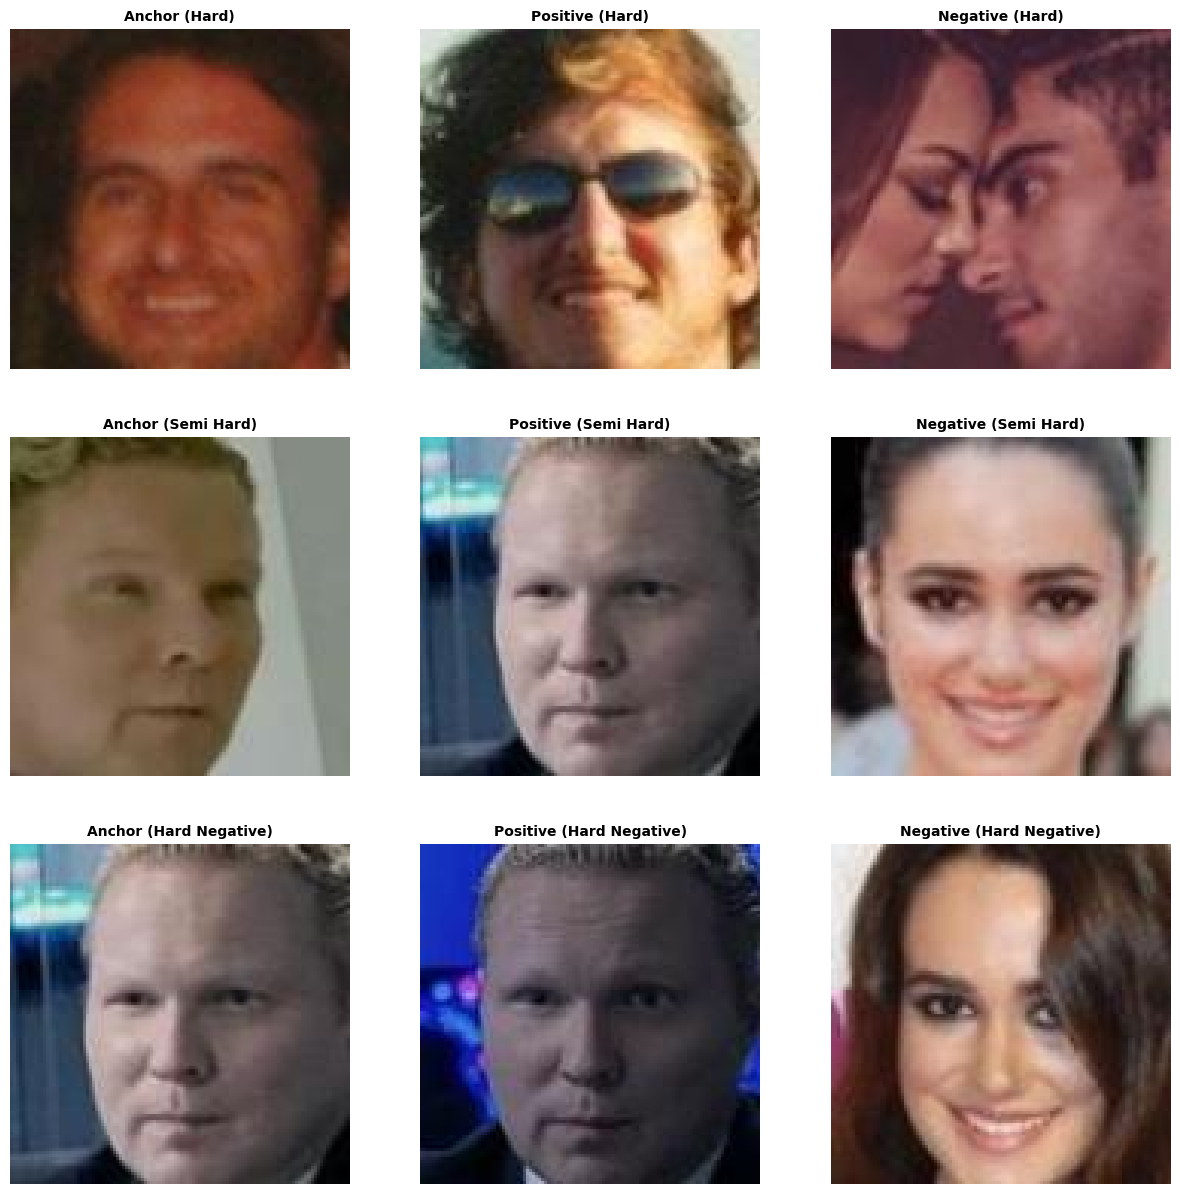

In [34]:
images = batch[1]

to_plot = (
keras.ops.take(images, indices=hard_sample[5], axis=0), keras.ops.take(images, indices=semi_hard_sample[5], axis=0),
keras.ops.take(images, indices=hard_negative_sample[5], axis=0))
labels = ['Hard', 'Semi Hard', 'Hard Negative']
version = ['Anchor', 'Positive', 'Negative']

# Visualise the sharpened image
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    current_set = to_plot[i]
    for j in range(3):
        axes[i, j].imshow(current_set[j, ...].numpy())
        axes[i, j].axis('off')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        axes[i, j].set_title(f'{version[j]} ({labels[i]})', fontsize=10, color='black', weight='bold')

plt.show()


e) You should now write and execute a custom training loop to train your model. Your custom training loop should use the `circle_loss` and `get_triplets` functions defined in parts b) and c).

Your custom training loop should use a Keras optimizer to perform the gradient updates. It should also record performance metrics as the training progresses. It is advised to structure your training loop to regularly save your model during training.

Display the final loss and any other performance metrics for your best trained model.

**(6 marks)**

The suggested implementation is inefficient because the `get_triplets` function has to do a forward pass but it does not return the embeddings which means we need to do a second forward pass to compute the loss function. We have not used this implementation. Instead, we replaced the `get_triplets` function with a function that takes the embeddings and labels and returns the list of triplet indices.

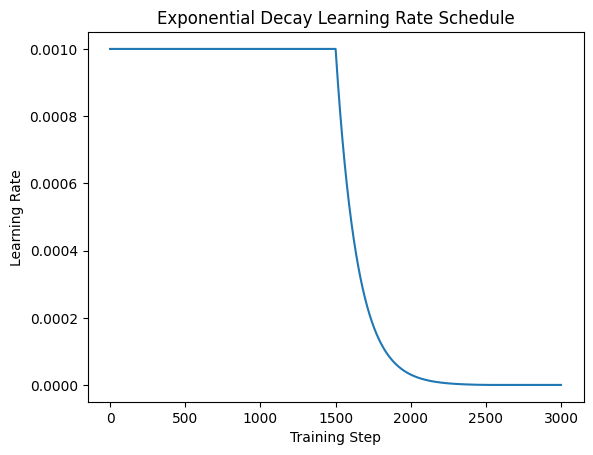

In [35]:
# This is adapted from the paper Hermans, A., Beyer, L., & Leibe, B. (2017). In Defense of the Triplet Loss for Person Re-Identification. ArXiv, abs/1703.07737.
class ExponentialDecaySchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=1e-3, t0=15000, t1=25000, final_factor=0.001):
        super().__init__()
        self.initial_lr = initial_lr
        self.t0 = t0
        self.t1 = t1
        self.final_factor = final_factor

    def __call__(self, step):
        # Convert step to float for division ops
        step = tf.cast(step, tf.float32)

        # Phase 1: before t0, lr is constant
        phase1 = tf.less_equal(step, self.t0)
        lr_phase1 = self.initial_lr

        # Phase 2: t0 < step <= t1, exponential decay
        decay_exponent = (step - self.t0) / (self.t1 - self.t0)
        lr_phase2 = self.initial_lr * tf.pow(self.final_factor, decay_exponent)

        # Phase 3: after t1, lr stays at final value
        phase3 = tf.greater(step, self.t1)
        lr_phase3 = self.initial_lr * self.final_factor

        # Select learning rate based on current phase
        return tf.where(phase1, lr_phase1,
                        tf.where(phase3, lr_phase3, lr_phase2))


lr_schedule = ExponentialDecaySchedule(initial_lr=1e-3, t0=1500, t1=2500, final_factor=0.001)
optimiser = keras.optimizers.Adam(learning_rate=lr_schedule)

steps = keras.ops.arange(0, 3000, dtype='float32')
lrs = [lr_schedule(s).numpy() for s in steps]

plt.plot(steps, lrs)
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Decay Learning Rate Schedule")
plt.show()


In [43]:
from IPython.display import clear_output
import csv

def plot(loss_values, title):
    clear_output()
    plt.figure(figsize=(8, 5))
    plt.plot(loss_values, label='Training loss', color='C0', linestyle='-')
    # plt.xlim((0, 100*128))
    plt.xlabel('Batch Number')
    plt.ylabel('Training Loss')
    plt.title(title)
    plt.show()

@tf.function
def training_step(batch, model, optimiser, triplet_fn, loss_fn):
    with tf.GradientTape() as tape:
        batch_labels, batch_images = batch
        embeddings = model(batch_images, training=True)
        triplets = triplet_fn(embeddings=embeddings, labels=batch_labels)
        anchor_embeddings = keras.ops.take(embeddings, indices=triplets[:, 0], axis=0)
        positive_embeddings = keras.ops.take(embeddings, indices=triplets[:, 1], axis=0)
        negative_embeddings = keras.ops.take(embeddings, indices=triplets[:, 2], axis=0)
        loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)

    grads = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(grads, model.trainable_variables))
    return loss


@tf.function
def validation_step(batch, model, loss_fn):
    batch_labels, batch_images = batch
    embeddings = model(batch_images, training=False)
    triplets = triplet_fn(embeddings=embeddings, labels=batch_labels)
    anchor_embeddings = keras.ops.take(embeddings, indices=triplets[:, 0], axis=0)
    positive_embeddings = keras.ops.take(embeddings, indices=triplets[:, 1], axis=0)
    negative_embeddings = keras.ops.take(embeddings, indices=triplets[:, 2], axis=0)
    loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
    return loss


def get_path(name, directory, fmt, postfix = ''):
    path = Path(f'./{directory}/{name}{postfix}.{fmt}')
    if path.exists():
        if postfix != '': postfix += 1
        else: postfix = 0
        return get_path(name=name, directory=directory, fmt=fmt, postfix=postfix)
    path.parent.mkdir(exist_ok=True, parents=True)
    return path

def recall_at_k(embeddings, labels, k=1):
    """
    Compute Recall@K. Use to monitor the training instead of the loss function
    """
    sims = keras.ops.matmul(embeddings, keras.ops.transpose(embeddings))
    sims = sims - keras.ops.eye(keras.ops.shape(sims)[0]) * 1e9  # Exclude self-similarity

    top_k = keras.ops.top_k(sims, k=k).indices
    labels = keras.ops.expand_dims(labels, axis=1)
    top_k_labels = keras.ops.take(labels, top_k)

    positive_matches = keras.ops.equal(top_k_labels, labels)
    recall = keras.ops.mean(keras.ops.any(positive_matches, axis=1), axis=0)
    return recall


def circle_loss_scheduler(epoch, base_m=0.2, base_gamma=64, step_size=20):
    '''
    Helper function to dynamically update the parameters in the circle loss.
    As the training progresses, we can increase the values of m and gamma
    '''
    m = base_m + (epoch // step_size) * 0.02
    gamma = base_gamma * (1 + (epoch // step_size) * 0.5)
    return partial(circle_loss, m=m, gamma=gamma)

# ---- Training Loop ----
best_recall_at_1 = 0.0
patience_counter = 0
log_path = get_path(name='SimpleEmbeddingNet_v4', directory='logs', fmt='csv')
chkpt_path = get_path(name='SimpleEmbeddingNet_v4', directory='models', fmt='weights.h5')

loss_fn = partial(circle_loss, m=0.2, gamma=64)
triplet_fn = hard_negative

epochs = 100
patience = 4

model = SimpleEmbeddingNetV2()
lr_schedule = ExponentialDecaySchedule(initial_lr=1e-3, t0=100, t1=20000, final_factor=0.001)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

@keras.saving.register_keras_serializable()
def training_step(batch, model, optimizer, triplet_fn, loss_fn):
    with K.GradientTape() as tape:
        batch_labels, batch_images = batch
        embeddings = model(batch_images, training=True)
        triplets = triplet_fn(embeddings=embeddings, labels=batch_labels)

        anchor_embeddings = K.take(embeddings, triplets[:, 0], axis=0)
        positive_embeddings = K.take(embeddings, triplets[:, 1], axis=0)
        negative_embeddings = K.take(embeddings, triplets[:, 2], axis=0)

        loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, embeddings, batch_labels

@keras.saving.register_keras_serializable()
def validation_step(batch, model, loss_fn):
    batch_labels, batch_images = batch
    embeddings = model(batch_images, training=False)

    triplets = triplet_fn(embeddings=embeddings, labels=batch_labels)

    anchor_embeddings = K.take(embeddings, triplets[:, 0], axis=0)
    positive_embeddings = K.take(embeddings, triplets[:, 1], axis=0)
    negative_embeddings = K.take(embeddings, triplets[:, 2], axis=0)

    loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
    recall = recall_at_k(embeddings, batch_labels, k=1)
    return loss, recall

with open(log_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['epoch', 'step', 'training_loss', 'recall@1'])

    step = 0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        loss_fn = circle_loss_scheduler(epoch)

        no_people = 32 if epoch < 30 else 50
        no_photos = 4 if epoch < 30 else 8

        train_dataloader = get_dataloader(no_people=no_people, no_photos=no_photos, shuffle=True, augment=True)

        minibatch_losses = []
        minibatch_recalls = []

        for i, batch in enumerate(train_dataloader):
            step += 1
            loss_value, embeddings, labels = training_step(
                batch=batch, model=model, optimizer=optimizer,
                triplet_fn=triplet_fn, loss_fn=loss_fn)

            recall_value = recall_at_k(embeddings, labels, k=1)

            minibatch_losses.append(K.convert_to_numpy(loss_value))
            minibatch_recalls.append(K.convert_to_numpy(recall_value))

            if i % 10 == 0:
                running_loss = np.mean(minibatch_losses)
                running_recall = np.mean(minibatch_recalls)

                print(f'\t[{epoch}: {i + 1}/{len(train_dataloader)}] Loss: {running_loss:.4f}, Recall@1: {running_recall:.4f}')
                writer.writerow([epoch, step, running_loss, running_recall])
                csv_file.flush()
                minibatch_losses = []
                minibatch_recalls = []

        val_batch = next(iter(get_dataloader(no_people=32, no_photos=10, shuffle=False, augment=False)))
        val_loss, val_recall = validation_step(val_batch, model, loss_fn)

        print(f'\tValidation Recall@1: {K.convert_to_numpy(val_recall):.4f}, Validation Loss: {K.convert_to_numpy(val_loss):.4f}')

        if val_recall > best_recall_at_1:
            best_recall_at_1 = val_recall
            patience_counter = 0
            print(f'\t[{epoch}/{epochs}] New Best Recall@1: {K.convert_to_numpy(best_recall_at_1):.4f}. Saving model...')
            model.save_weights(chkpt_path, overwrite=True)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\t[{epoch}/{epochs}] Early stopping triggered after {patience_counter} epochs without improvement.')
                break

print('---------Training Completed------------')


In [86]:
import json
best_loss = float('inf')
patience_counter = 0
name = 'SimpleEmbeddingNet'
log_path = get_path(name=name, directory='logs', fmt='csv')
chkpt_path = get_path(name=name, directory='models', fmt='weights.h5')
meta_path = get_path(name=name, directory='meta', fmt='txt')
val_batch = next(iter(get_dataloader(shuffle=False, augment=False)))
optimiser = keras.optimizers.Adam(lr_schedule)
loss_fn = partial(circle_loss, m=0.2, gamma=25)
triplet_fn = semi_hard
epochs = 100
patience = 10
model = SimpleEmbeddingNet()

meta_data = dict(model=model.name, patience=patience, epochs=epochs, triplet_fn=triplet_fn.__name__, optimiser=optimiser.name, learning_rate=optimiser.learning_rate.numpy(), loss_fn_kwargs=loss_fn.keywords, model_path=chkpt_path.name,
                 learning_schedule=lr_schedule.__dict__)
with open(meta_path, 'w') as f:
    json.dump(meta_data, f)


losses = []
step = 0
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    # ---- TRAINING PHASE ----
    train_dataloader = get_dataloader(shuffle=True, augment=True)
    epoch_training_loss = 0.0
    batches = len(train_dataloader)

    for i, batch in enumerate(train_dataloader):
        step += 1
        loss_value = training_step(
            batch=batch, model=model, optimiser=optimiser,
            triplet_fn=triplet_fn, loss_fn=loss_fn)
        epoch_training_loss += loss_value
        losses.append(loss_value)
        if i % 10 == 0:
            avg_loss = epoch_training_loss/i
            print(f'\t[{epoch}: {i + 1}/{batches}] Running Avg Loss: {avg_loss:.4f}')
            writer.writerow([epoch, step, avg_loss.numpy()])
            csv_file.flush()

    avg_train_loss = epoch_training_loss / batches

    print(f'\t[{epoch}/{epochs}] Average Training Loss: {avg_train_loss:.4f}')

    # ---- EARLY STOPPING & CHECKPOINTING ----
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        patience_counter = 0
        print(f'\t[{epoch}/{epochs}] New Best Validation Loss. Saving model to {chkpt_path}...')
        model.save_weights(chkpt_path, overwrite=True)  # in .keras format by default
    else:
        patience_counter += 1
        if patience_counter < patience:
            print(f'\t[{epoch}/{epochs}] Early stopping triggered. Loss not improved in {patience_counter} epochs')

        elif patience_counter >= patience:
            print(f'\t[{epoch}/{epochs}] Early stopping triggered {patience_counter}. Terminating training')
            break

print('---------Training Completed------------')


{'initial_lr': 0.001, 't0': 1500, 't1': 2500, 'final_factor': 0.001}

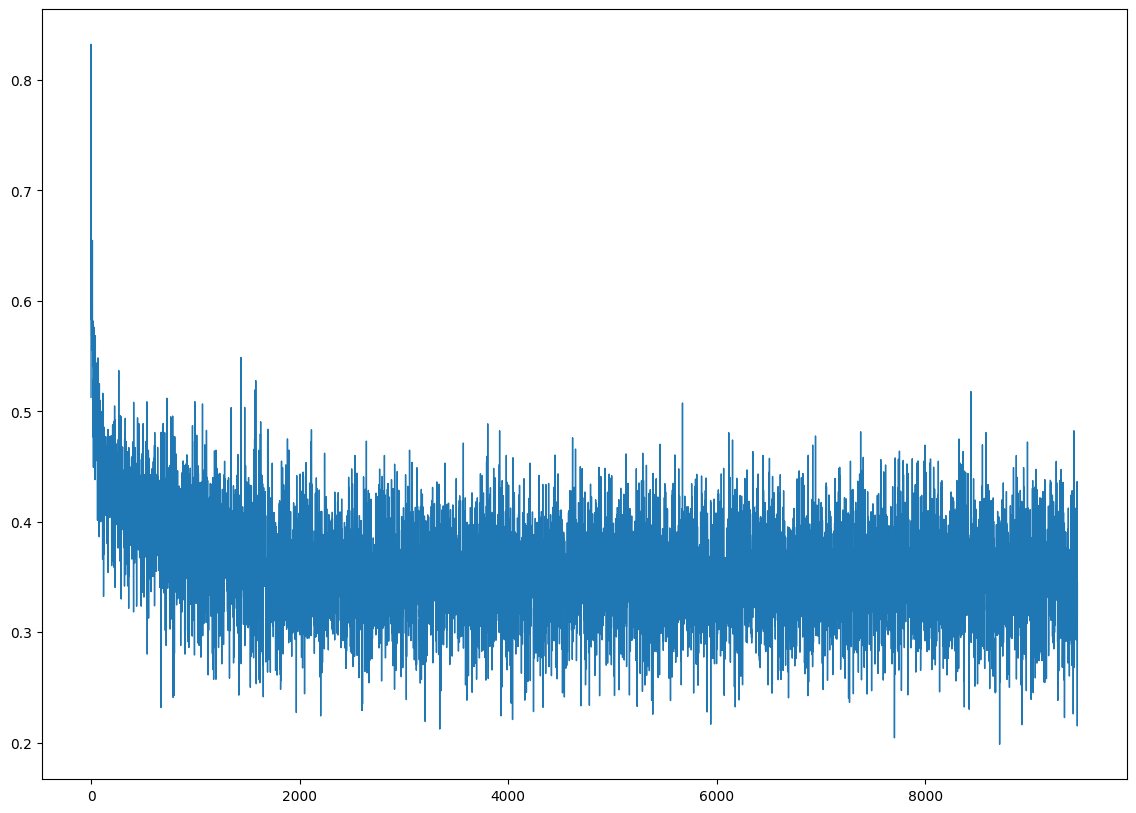

In [216]:
losses = [x.numpy() for x in losses]
df = pd.DataFrame(dict(losses=losses, step=np.arange(len(losses))))
df.to_csv(path=log_path, index=False)

fig = plt.figure(figsize=(14, 10))
plt.plot(vals, linewidth=1, color='C0')
plt.show()

In [ ]:
best_loss = float('inf')
patience_counter = 0
log_path = get_path(name='SimpleEmbeddingNet_v3', directory='logs', fmt='csv')
chkpt_path = get_path(name='SimpleEmbeddingNet_v3', directory='models', fmt='weights.h5')
val_batch = next(iter(get_dataloader(no_people=32, no_photos=10, shuffle=False, augment=False)))
loss_fn = partial(circle_loss, m=0.2, gamma=256)
triplet_fn = hard_negative
epochs = 100
patience = 4
model = SimpleEmbeddingNetV2()

lr_schedule = ExponentialDecaySchedule(initial_lr=1e-3, t0=100, t1=20000, final_factor=0.001)

optimiser = keras.optimizers.Adam(learning_rate=lr_schedule)


@tf.function
def training_step(batch, model, optimiser, triplet_fn, loss_fn):
    with tf.GradientTape() as tape:
        batch_labels, batch_images = batch
        embeddings = model(batch_images, training=True)
        triplets = triplet_fn(embeddings=embeddings, labels=batch_labels)
        anchor_embeddings = keras.ops.take(embeddings, indices=triplets[:, 0], axis=0)
        positive_embeddings = keras.ops.take(embeddings, indices=triplets[:, 1], axis=0)
        negative_embeddings = keras.ops.take(embeddings, indices=triplets[:, 2], axis=0)
        loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)

    grads = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(grads, model.trainable_variables))
    return loss


@tf.function
def validation_step(batch, model, loss_fn):
    batch_labels, batch_images = batch
    embeddings = model(batch_images, training=False)
    triplets = triplet_fn(embeddings=embeddings, labels=batch_labels)
    anchor_embeddings = keras.ops.take(embeddings, indices=triplets[:, 0], axis=0)
    positive_embeddings = keras.ops.take(embeddings, indices=triplets[:, 1], axis=0)
    negative_embeddings = keras.ops.take(embeddings, indices=triplets[:, 2], axis=0)
    loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
    return loss


with open(log_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['epoch', 'step', 'training_loss'])  # header row
    losses = []
    step = 0
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        # ---- TRAINING PHASE ----
        train_dataloader = get_dataloader(no_people=50, no_photos=8,
                                          shuffle=True, augment=True)
        batches = len(train_dataloader)
        minibatch_losses = []
        epoch_losses = []
        for i, batch in enumerate(train_dataloader):
            step += 1
            loss_value = training_step(
                batch=batch, model=model, optimiser=optimiser,
                triplet_fn=triplet_fn, loss_fn=loss_fn)
            losses.append(loss_value)
            epoch_losses.append(loss_value)
            minibatch_losses.append(loss_value)
            if i % 10 == 0:
                running_avg = sum(epoch_losses)/len(epoch_losses)
                current_avg = sum(minibatch_losses)/len(minibatch_losses)
                print(f'\t[{epoch}: {i + 1}/{batches}] Running Avg Loss: {running_avg:.4f}\t Minibatch Avg Loss: {current_avg:.4f}')
                minibatch_losses = []
                # print(f'\tLearning Rate {optimiser.learning_rate}')
                writer.writerow([epoch, step, avg_loss.numpy()])
                csv_file.flush()
                cnt = 0

        avg_train_loss = sum(epoch_losses) / len(epoch_losses)

        # ---- LOGGING ----
        writer.writerow([epoch, step, avg_train_loss])
        csv_file.flush()  # ensure data is written to disk immediately
        print(f'\t[{epoch}/{epochs}] Average Training Loss: {avg_train_loss:.4f}')

        # ---- EARLY STOPPING & CHECKPOINTING ----
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            patience_counter = 0
            print(f'\t[{epoch}/{epochs}] New Best Validation Loss. Saving model to {chkpt_path}...')
            model.save_weights(chkpt_path, overwrite=True)  # in .keras format by default
        else:
            patience_counter += 1
            if patience_counter < patience:
                print(f'\t[{epoch}/{epochs}] Early stopping triggered. Loss not improved in {patience_counter} epochs')

            elif patience_counter >= patience:
                print(f'\t[{epoch}/{epochs}] Early stopping triggered {patience_counter}. Terminating training')
                break

print('---------Training Completed------------')

logs/SimpleEmbeddingNet_v3.csv
models/SimpleEmbeddingNet_v3.weights.h5

Epoch 1/100


<tf.Tensor: shape=(), dtype=float32, numpy=0.7272033>

#### Question 3 (Total 7 marks)

In this question you will view your trained model as a binary classifier that predicts whether two images are the same person or not. You will test your trained model on a subset of the Labeled Faces in the Wild (LFW) dataset. This dataset also consists of a number of identities, and a number of images per identity. It was introduced in the following paper:

* Huang, G.B., Ramesh, M., Berg, T., and Learned-Miller, E. (2007), "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments", University of Massachusetts, Amherst, Technical Report 07-49.

The subset is available for you in the folder `./data/labeled-faces-in-the-wild`.  There is also the file `lfw_test_pairs.txt` in the `./data` folder that you will use for testing. This file lists a number of pairs of images in the LFW dataset that either belong to the same identity or different identities.

_NB: if you have not been able to successfully train a model in question 2, you can still complete all of question 3 using any Keras model that takes images as input and returns embeddings. The results may not be good, but you can still demonstrate the methodology and implementation for testing the model._

a) You will now use your best model from question 2 to compute predictions on the LFW subset to say whether or not two images are the same person. 

Apply any appropriate data preprocessing to the images, and compute model embeddings and similarity scores for all images in the test data.

Display a histogram with the distribution of positive and negative similarity scores from your model.

**(4 marks)**

In [249]:
# --- Helper Functions ---
def get_paths():
    file = Path('./data/lfw_test_pairs.txt')
    img_dir = Path('./data/labeled-faces-in-the-wild')
    paths = []
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split()
            if len(line) == 3:
                person = line[0]
                photos = [f"{person}_{'0' * (4 - len(x))}{x}.jpg" for x in line[1:]]
                paths.append((os.path.join(img_dir, person, photos[0]),
                              os.path.join(img_dir, person, photos[1]),
                              1))
            elif len(line) == 4:
                person1, person2 = line[0], line[2]
                photos = [f"{person1}_{'0' * (4 - len(line[1]))}{line[1]}.jpg",
                          f"{person2}_{'0' * (4 - len(line[3]))}{line[3]}.jpg"]
                paths.append((os.path.join(img_dir, person1, photos[0]),
                              os.path.join(img_dir, person2, photos[1]),
                              0))
    return paths


class LFIWDataset(torch.utils.data.Dataset):
    def __init__(self, paths: list, img_transforms: Optional[list]):
        '''
        Load the Faces in the wild into a dataset
        Args:
            paths: list of tuples with (image_path, image_path, label) where label is 1 if it's the same person and 0 if it's a different person
            img_transforms: A list of image transforms to be applied to each image
        '''
        self.paths = paths
        if img_transforms:
            self.extra_transforms = img_transforms
        else:
            self.extra_transforms = []
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.ConvertImageDtype(torch.float32),
                                              transforms.Resize((112, 112))] + self.extra_transforms)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        item = self.paths[idx]
        img_paths, label = item[:2], item[2]

        img_list = []
        for img_path in img_paths:
            img = Image.open(img_path)  # already in RGB here.
            img_tensor = self.transforms(img)
            img_list.append(img_tensor)

        img_tensor = torch.stack(img_list, dim=0)  # shape N, C, H, W
        img_tensor = img_tensor.permute(0, 2, 3, 1)
        label_tensor = torch.tensor(label).unsqueeze(0)
        return label_tensor, img_tensor

def collate(batch):
    labels, images = zip(*batch)
    labels = torch.cat(labels, dim=0)
    images = torch.cat(images, dim=0)
    return labels, images

def LFIWDataloader(paths: list, image_transforms: Optional[list]):
    '''
        Function to get the dataloader for the LFIW dataset
    '''
    dataset = LFIWDataset(paths, image_transforms)
    return torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False, drop_last=False, collate_fn=None)


lfiw_dl = LFIWDataloader(paths=get_paths(), image_transforms=None)

pd.DataFrame(get_paths(), columns=['Image1', 'Image2', 'Label']).groupby('Label').apply('count')

,Image1,Image2
Label,,
0,3000,3000
1,3000,3000


In [250]:
batch = next(iter(lfiw_dl))
labels, imgs = batch

In [251]:
inputs = imgs.flatten().reshape((12000, 112, 112, 3))
# new_model = SimpleEmbeddingNet().load_weights()
embeddings = model.predict(inputs)

375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


In [252]:
embeddings = embeddings.reshape(6000, 2, 128)
left_img = embeddings[:, 1, :]
right_img = embeddings[:, 0, :]
cos_sims = scaled_cosine_similarity(left_img, right_img)
cos_sims_numpy = cos_sims.numpy()
res = pd.DataFrame({'cos_similarities': cos_sims_numpy, 'labels': labels.squeeze().numpy()})

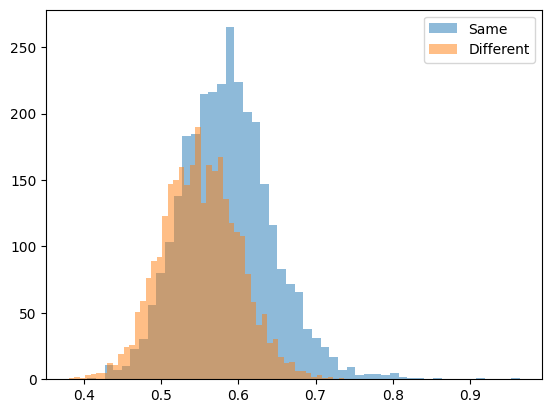

In [253]:
plt.hist(res[res.labels==1].cos_similarities, label='Same', alpha=0.5, bins=50)
plt.hist(res[res.labels==0].cos_similarities, label='Different', alpha=0.5, bins=50)
plt.legend()
plt.show()

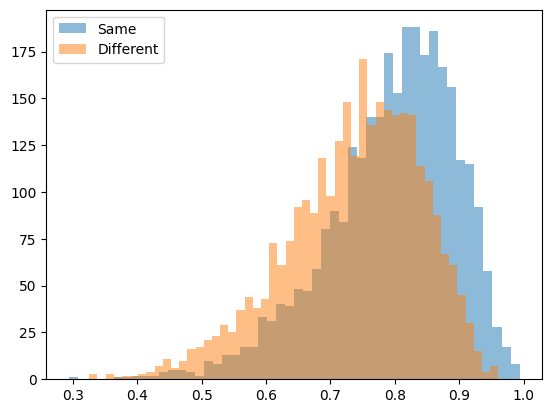

In [221]:
plt.hist(res[res.labels==1].cos_similarities, label='Same', alpha=0.5, bins=50)
plt.hist(res[res.labels==0].cos_similarities, label='Different', alpha=0.5, bins=50)
plt.legend()
plt.show()

In [85]:

# --- Compute Embeddings and Similarity Scores ---
similarity_positive = []  # scores for pairs of the same person
similarity_negative = []  # scores for pairs of different persons
i = 0
for batch in lfiw_dl:
    label, imgs = batch
    embeddings = model.predict(imgs)
    similarity = scaled_cosine_similarity(embeddings[0], embeddings[1])
    if label == 1:
        print(label)
        similarity_positive.append(similarity)
    else:
        similarity_negative.append(similarity)

# print(imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tensor(1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
tens

KeyboardInterrupt: 

In [84]:
label.shape
imgs.shape

torch.Size([2, 112, 112, 3])

In [ ]:
# Loop over each pair, preprocess the images, compute embeddings, and then similarity.
for img1_path, img2_path, label in pairs:
    # Make sure paths are correct; adjust as necessary (e.g., prepend data folder)
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)

    # Compute embeddings using your trained model.
    # Here, model.predict returns a batch so we extract the first (and only) result.
    emb1 = model.predict(img1)[0]
    emb2 = model.predict(img2)[0]

    # Compute the scaled cosine similarity.
    score = scaled_cosine_similarity(emb1, emb2)

    # Collect scores based on the label.
    if label == 1:  # positive pair: same person
        similarity_positive.append(score)
    else:  # negative pair: different persons
        similarity_negative.append(score)

# --- Plot Histograms of Similarity Scores ---

plt.figure(figsize=(10, 6))
plt.hist(similarity_positive, bins=50, alpha=0.7, label='Positive Pairs (Same Person)')
plt.hist(similarity_negative, bins=50, alpha=0.7, label='Negative Pairs (Different Persons)')
plt.xlabel('Scaled Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores on LFW Test Pairs')
plt.legend()
plt.show()

# --- Optional: Simple Classifier Based on Threshold ---

# For example, you might choose a threshold of 0.5.
threshold = 0.5


def classify_pair(score, threshold=threshold):
    """Return 1 if same person, 0 otherwise."""
    return 1 if score >= threshold else 0


# Compute predictions and accuracy (if true labels are available).
predictions = []
true_labels = []
for img1_path, img2_path, label in pairs:
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    emb1 = model.predict(img1)[0]
    emb2 = model.predict(img2)[0]
    score = scaled_cosine_similarity(emb1, emb2)
    pred = classify_pair(score)
    predictions.append(pred)
    true_labels.append(label)

accuracy = np.mean(np.array(predictions) == np.array(true_labels))
print(f'Classifier accuracy with threshold {threshold}: {accuracy:.2%}')


['10', '300']
['Abel_Pacheco', '1', '4']
['Akhmed_Zakayev', '1', '3']
['Akhmed_Zakayev', '2', '3']
['Amber_Tamblyn', '1', '2']
['Anders_Fogh_Rasmussen', '1', '3']
['Anders_Fogh_Rasmussen', '1', '4']
['Angela_Bassett', '1', '5']
['Angela_Bassett', '2', '5']
['Angela_Bassett', '3', '4']
['Ann_Veneman', '3', '5']
['Ann_Veneman', '6', '10']
['Ann_Veneman', '10', '11']
['Anthony_Fauci', '1', '2']
['Antony_Leung', '1', '2']
['Antony_Leung', '2', '3']
['Anwar_Ibrahim', '1', '2']
['Augusto_Pinochet', '1', '2']
['Barbara_Brezigar', '1', '2']
['Benjamin_Netanyahu', '1', '4']
['Benjamin_Netanyahu', '4', '5']
['Bernard_Law', '2', '3']
['Bernard_Law', '3', '4']
['Bertrand_Bonello', '1', '2']
['Bill_Frist', '2', '9']
['Bill_Frist', '4', '5']
['Bob_Graham', '2', '4']
['Bob_Graham', '3', '6']
['Bob_Graham', '4', '6']
['Bob_Graham', '5', '6']
['Boris_Becker', '2', '6']
['Brad_Johnson', '1', '3']
['Brad_Johnson', '2', '3']
['Brad_Johnson', '2', '4']
['Brian_Griese', '1', '2']
['Candice_Bergen', '1', '2'

b) Use the computed similarity scores from part a) to calculate the area under the ROC curve and the area under the precision-recall (PR) curve for your classifier model. Use the Keras `AUC` metric (see [the docs](https://keras.io/api/metrics/classification_metrics/#auc-class)) to do this.

Compute the threshold that maximises the accuracy of your classifier on the LFW test data. Plot the accuracy as a function of the threshold, and report the optimal threshold and resulting accuracy.

**(3 marks)**

#### Question 4 (Total 10 marks)

Provide a separate PDF report with an account of the experiments you have run in question 2. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time? What do you think are the most promising directions for performance gains?

Marks will be awarded for presentation and clarity. Your report should be no more than 3 pages, excluding references.

**(10 marks)**